In [5]:



# synthetic data
from datetime import datetime

import os, os.path
import torchvision.transforms.functional as TF
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import torch
import math
import sys
from skimage.transform import rescale, resize, downscale_local_mean
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import numpy as np

import random
from random import randrange
import tqdm
import fnmatch
import cv2

import pandas as pd
import lifelines
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test,multivariate_logrank_test
kmf = KaplanMeierFitter()



# Following functions help customize KM plots 

In [6]:
# SURVIVAL ANALYSIS PLOTTING FUNCTIONS: copied from github/lifelines and edited for customization
def is_latex_enabled(): 
    '''
    Returns True if LaTeX is enabled in matplotlib's rcParams,
    False otherwise
    '''
    import matplotlib as mpl

    return mpl.rcParams['text.usetex']


def remove_spines(ax, sides):
    '''
    Remove spines of axis.
    Parameters:
      ax: axes to operate on
      sides: list of sides: top, left, bottom, right
    Examples:
    removespines(ax, ['top'])
    removespines(ax, ['top', 'bottom', 'right', 'left'])
    '''
    for side in sides:
        ax.spines[side].set_visible(False)
    return ax


def move_spines(ax, sides, dists):
    '''
    Move the entire spine relative to the figure.
    Parameters:
      ax: axes to operate on
      sides: list of sides to move. Sides: top, left, bottom, right
      dists: list of float distances to move. Should match sides in length.
    Example:
    move_spines(ax, sides=['left', 'bottom'], dists=[-0.02, 0.1])
    '''
    for side, dist in zip(sides, dists):
        ax.spines[side].set_position(('axes', dist))
    return ax


def remove_ticks(ax, x=False, y=False):
    '''
    Remove ticks from axis.
    Parameters:
      ax: axes to work on
      x: if True, remove xticks. Default False.
      y: if True, remove yticks. Default False.
    Examples:
    removeticks(ax, x=True)
    removeticks(ax, x=True, y=True)
    '''
    if x:
        ax.xaxis.set_ticks_position('none')
    if y:
        ax.yaxis.set_ticks_position('none')
    return ax

def add_at_risk_counts_CUSTOM(fitters,**kwargs): 
    '''
    Add counts showing how many individuals were at risk at each time point in
    survival/hazard plots.
    Arguments:
      One or several fitters, for example KaplanMeierFitter,
      NelsonAalenFitter, etc...
    Keyword arguments (all optional):
      ax: The axes to add the labels to. Default is the current axes.
      fig: The figure of the axes. Default is the current figure.
      labels: The labels to use for the fitters. Default is whatever was
              specified in the fitters' fit-function. Giving 'None' will
              hide fitter labels.
    Returns:
      ax: The axes which was used.
    Examples:
        # First train some fitters and plot them
        fig = plt.figure()
        ax = plt.subplot(111)
        f1 = KaplanMeierFitter()
        f1.fit(data)
        f1.plot(ax=ax)
        f2 = KaplanMeierFitter()
        f2.fit(data)
        f2.plot(ax=ax)
        # There are equivalent
        add_at_risk_counts(f1, f2)
        add_at_risk_counts(f1, f2, ax=ax, fig=fig)
        # This overrides the labels
        add_at_risk_counts(f1, f2, labels=['fitter one', 'fitter two'])
        # This hides the labels
        add_at_risk_counts(f1, f2, labels=None)
    '''

    # Axes and Figure can't be None
    ax = kwargs.get('ax', None)
    if ax is None:
        ax = plt.gca()

    fig = kwargs.get('fig', None)
    if fig is None:
        fig = plt.gcf()

    fontsize = kwargs.get('fontsize', None)
    if fontsize is None:
        fontsize = 30
        
    if 'labels' not in kwargs:
        labels = [f._label for f in fitters]
        #print(labels)
    else:
        # Allow None, in which case no labels should be used
        labels = kwargs['labels']
        
        if labels is None:
            labels = [None] * len(fitters)
    # Create another axes where we can put size ticks
    ax2 = plt.twiny(ax=ax)
    # Move the ticks below existing axes
    # Appropriate length scaled for 6 inches. Adjust for figure size.
    ax2_ypos = -0.20 * 6.0 / fig.get_figheight()
    move_spines(ax2, ['bottom'], [ax2_ypos])
    # Hide all fluff
    remove_spines(ax2, ['top', 'right', 'bottom', 'left'])
    # Set ticks and labels on bottom
    ax2.xaxis.tick_bottom()
    # Match tick numbers and locations
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xlim(ax.get_xlim())
    colors=kwargs['colors']
    # Remove ticks, need to do this AFTER moving the ticks
    remove_ticks(ax2, x=True, y=True)
    # Add population size at times
    ticklabels = []
    for tick in ax2.get_xticks():
        lbl = ""
        for f, l in zip(fitters, labels):
            # First tick is prepended with the label
            #print(f,l)
            if tick == ax2.get_xticks()[0] and l is not None:
                if is_latex_enabled():
                    s = "\n{}\\quad".format(l) + "{}"
                else:
                    s = "\n{}   ".format(l) + "{}"
            else:
                s = "\n{}"
            lbl += s.format(f[f >= tick].shape[0])
        ticklabels.append(lbl.strip())
    # Align labels to the right so numbers can be compared easily
    #print(ticklabels[1])
    ax2.set_xticklabels(ticklabels, ha='right', fontsize=fontsize)

    # Add a descriptive headline.
    ax2.xaxis.set_label_coords(0, ax2_ypos)
    ax2.set_xlabel('At risk', fontsize=fontsize,ha='right',color='r')

    plt.tight_layout()
    return ax2,ticklabels

# following function plots the km curves and produce lists required to calculate multivariate log-rank test

In [7]:
def plot_km(col,df,T,C,colors):
    '''
    
    '''
    #plt.figure()
    kmf = KaplanMeierFitter()
    ax = plt.subplot(111)
     # Create another axes where we can put size ticks
    fitters=[]
    labels=[]
    df_d=pd.DataFrame()
    df_E=pd.DataFrame()
    G=[]
    if (colors is None):
        from matplotlib.pyplot import cm
        #c_values= cm.rainbow(np.linspace(0, 1, len(df[col].unique())))
        c_values=plt.cm.tab20(range(0,len(df[col].unique())))
        colors=dict(zip(df[col].unique(),c_values))
    j=0
    timeline = [1, 2, 4]
    for r in df[col].unique():
        
        ix = df[col] == r
        c=kmf.fit(durations=T[ix], event_observed=C[ix],label=r)
        #print(r,c.survival_function_at_times(timeline))
        fitters.append(c.durations)
        df_d=pd.concat([df_d.reset_index(drop=True),T[ix].reset_index(drop=True)],axis=0)
        df_E=pd.concat([df_E.reset_index(drop=True),C[ix].reset_index(drop=True)],axis=0)
        G.append(np.zeros(len(T[ix]))+j) #required to compute log-rank test p-value
        
        labels.append(r)
        kmf.plot(ax=ax,ci_show=False, show_censors=True,c=colors[r])
        plt.ylim([0,1.1])
        plt.yticks(np.arange(0, 1.1, step=0.2))
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylabel('Survival probability',fontsize=20)
        plt.xlabel('Time in years',fontsize=20)
        if len(df[col].unique())>3:
            plt.legend(bbox_to_anchor=(0, 1.3, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)
        else:
            plt.legend(loc="upper left", mode = "expand", ncol = 3)
            plt.legend(loc="upper right",frameon=False,fontsize="30")
        plt.legend(labelcolor='linecolor')
        ax.grid(False)
        j+=1
    d_list=df_d.values.tolist()#required to compute log-rank test p-value (time)
    e_list=df_E.values.tolist()#required to compute log-rank test p-value (event)
    d_list=np.hstack(d_list)
    e_list=np.hstack(e_list)
    G=np.hstack(G)
    return fitters,labels,ax,d_list,e_list,G,colors

# Figure 2(B) and 2(C)

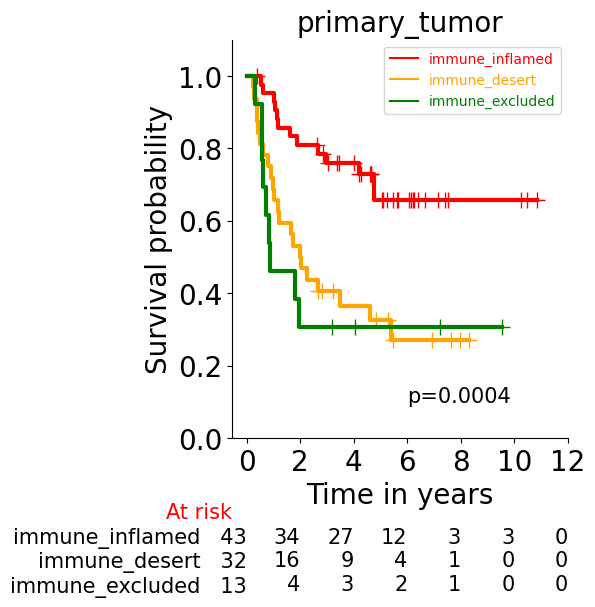

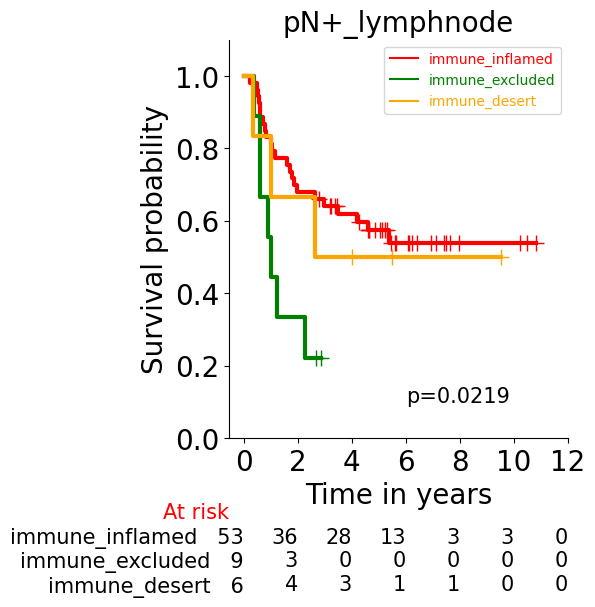

In [9]:
#following function produces KM plots based on H&E subtypes
def plot_km_region_HE_subtypes(region):
    ''' region: options primary_tumor or pN+_lymphnode '''
    if region=="primary_tumor":
        path="Immune_pheno_tum_til_density.csv"
        df=pd.read_csv(path)  
        T=df['Years to Progression or Last Follow-up']
        C=df['Case'].astype(float)
        col="Immune_ph"
    else:
        path="Immune_pheno_LN_tum_til_density.csv"
        df=pd.read_csv(path)   
        T=df['Years to Progression or Last Follow-up']
        C=df['Case'].astype(float)
        col="Immune_ph_LN"

    colors={"immune_excluded":"g","immune_desert":"orange","immune_inflamed":"red"}
    plt.figure(figsize=(6,6))
    fitters,labels,ax,d_list,e_list,G,colors=plot_km(col,df,T,C,colors) 

    df_rank = pd.DataFrame({
        'durations': d_list,
        'events': e_list,
        'groups': G
    })
    result = multivariate_logrank_test(df_rank['durations'], df_rank['groups'], df_rank['events'])
    result.test_statistic



    sns.despine()
    newxticks = []
    for x in ax.get_xticks():
        if x >= 0:
            newxticks += [x]

    ax.set_xticks(newxticks)

    plt.text(6,.1,'p={}'.format(round(result.p_value,4),'.3f'),fontsize=15)
    for line in plt.gca().lines:
        line.set_linewidth(3.)
    ax2=add_at_risk_counts_CUSTOM(fitters,ax=ax,fontsize=15,labels=labels,colors=colors)
    plt.title(f'{region}', fontsize=20)
    plt.show()
        
regions=["primary_tumor","pN+_lymphnode"]

for region in regions:
    plot_km_region_HE_subtypes(region)
    

# Figure 3(A) and supplementary figure S6(A,B)

In [ ]:


def plot_km_region_HE_IHC_int_subtypes(region):
    '''region: options Tumor-for primary tumor, LN- for pN+ lymph node'''
    #marker list to read corresponding csvs
    marker_list=["CD163","CD20","CD3","CD4","CD45","CD8","ER-Alpha","ER-Beta","FoxP3","PD-L1","KRT-AE1AE3"]
    #median thresholding column in csv to quantify protein expression
    mode="median"
    for  i in marker_list:
        df=pd.read_csv(f"HE_IHC_comb_IN_{region}/" + i + "_quant_patient{}.csv".format(region))

        T=df['Years to Progression or Last Follow-up']
        C=df['Case'].astype(float)
        col="col_comb_gr"
        df[col] = df[col].apply(lambda x : 'immune_excluded' if "immune_excluded" in x else ("immune_desert" if "immune_desert" in x else x))
        colors={f'IN_{i}_high': 'r', f'IN_{i}_low': 'pink',"IE":"g","ID":"orange"}
        order_labels={f'IN_{i}_high':0, f'IN_{i}_low':1,"IE":2,"ID":3}
        plt.figure(figsize=(8,8))
        fitters,labels,ax,d_list,e_list,G,colors=plot_km(col,df,T,C,colors) 

        df_rank = pd.DataFrame({
            'durations': d_list,
            'events': e_list,
            'groups': G
        })
        result = multivariate_logrank_test(df_rank['durations'], df_rank['groups'], df_rank['events'])
        result.test_statistic



        sns.despine()
        newxticks = []
        for x in ax.get_xticks():
            if x >= 0:
                newxticks += [x]

        ax.set_xticks(newxticks)
        if result.p_value< 0.05:
            plt.title('{}_{}**'.format(i,region), fontsize=20)
        else:
            plt.title('{}_{}'.format(i,region),fontsize=20)
        plt.text(6,.1,'p={}'.format(round(result.p_value,4)),fontsize=15)
        for line in plt.gca().lines:
            line.set_linewidth(3.)
        ax.legend().set_visible(False) 
        handles, labels = ax.get_legend_handles_labels()
        order=[]
        for l in labels:
            order.append(order_labels[l])
        order = np.argsort(order)
        #ax.legend().set_visible(False)
        ax2=add_at_risk_counts_CUSTOM(fitters,ax=ax,fontsize=15,labels=labels,colors=colors)
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
        #ax.legend().set_visible(True) 
        #if i!="CD3":
        #ax.legend().set_visible(False)   
        #plt.savefig('combined_IHC_H&E_KM_{}/KM_{}_{}_IN_sub.png'.format(region,mode,i),dpi=500)
regions=["Tumor","LN"]
for region in regions:
    plot_km_region_HE_IHC_int_subtypes(region)


In [ ]:
#to plot the combination of markers the last row of figure 3(A)

def plot_KM_comb(comb_mark,region): 
    mode="median"
  
    for i,j in comb_mark:
        df_1=pd.read_csv(f"HE_IHC_comb_IN_{region}/" + i + "_quant_patient{}.csv".format(region))
        df_2=pd.read_csv(f"HE_IHC_comb_IN_{region}/" + j + "_quant_patient{}.csv".format(region))
        df_2=df_2[["MRN","dich_gr"]].rename(columns={"dich_gr":f'col_comb_gr_{j}'})
        df_1=df_1.rename(columns={"dich_gr":f'col_comb_gr_{i}'})
        df=df_1.merge(df_2, on="MRN",how="inner")
        
        if region=="Tumor":
            df["col_comb_gr"]=df["Immune_ph"]+ f" {i} "+df[f"col_comb_gr_{i}"]+ f" {j} "+df[f"col_comb_gr_{j}"]
            df_in=df[df["Immune_ph"]=="IN"]
        else:
            df["col_comb_gr"]=df["Immune_ph_LN"]+ f" {i} "+df[f"col_comb_gr_{i}"]+ f" {j} "+df[f"col_comb_gr_{j}"]
            df_in=df[df["Immune_ph_LN"]=="IN"]
        col="col_comb_gr"
        #df[col] = df[col].apply(lambda x : 'IE' if "IE" in x else ("ID" if "ID" in x else x))
        #df.to_csv(f"comb_{i}_{j}_IN.csv")
        
        df=df_in
        T=df['Years to Progression or Last Follow-up']
        C=df['Case'].astype(float)
        colors={f'IN {i} high {j} low':"red", f'IN {i} low {j} high':"pink",f'IN {i} high {j} high':"brown", f'IN {i} low {j} low':"orange"}
        df.to_csv(f"comb_{i}_{j}_IN.csv")
        plt.figure(figsize=(8,8))
        fitters,labels,ax,d_list,e_list,G,colors=plot_km(col,df,T,C,colors) 
        df_rank = pd.DataFrame({
            'durations': d_list,
            'events': e_list,
            'groups': G
        })
        result = multivariate_logrank_test(df_rank['durations'], df_rank['groups'], df_rank['events'])
        result.test_statistic
        sns.despine()
        newxticks = []
        for x in ax.get_xticks():
            if x >= 0:
                newxticks += [x]

        ax.set_xticks(newxticks)
        
        if result.p_value< 0.05:
            plt.title('comb_{}_{}_{}**'.format(i,j,region), fontsize=20)          
        else:
            plt.title('comb_{}_{}_{}'.format(i,j,region), fontsize=20)
        
                #ax.legend(loc=2, ncol=1, mode="expand", borderaxespad=0)
        plt.text(6,.4,'p={}'.format(round(result.p_value,4)),fontsize=20)
        for line in plt.gca().lines:
            line.set_linewidth(3.)
        ax2=add_at_risk_counts_CUSTOM(fitters,ax=ax,fontsize=15,labels=labels,colors=colors)
        plt.rcParams["axes.edgecolor"] = "black"
        plt.rcParams["axes.linewidth"] = 2.50
        #plt.savefig('diff_combinations_IHC_{}/KM_{}_{}_IN_sub.png'.format(region,i,j),dpi=500)
        

regions=["Tumor","LN"]
comb_mark=["CD163","CD8"]
for region in regions:
    plot_KM_comb(zip([comb_mark[0]],[comb_mark[1]]),region)

# Supplementary Figure S1

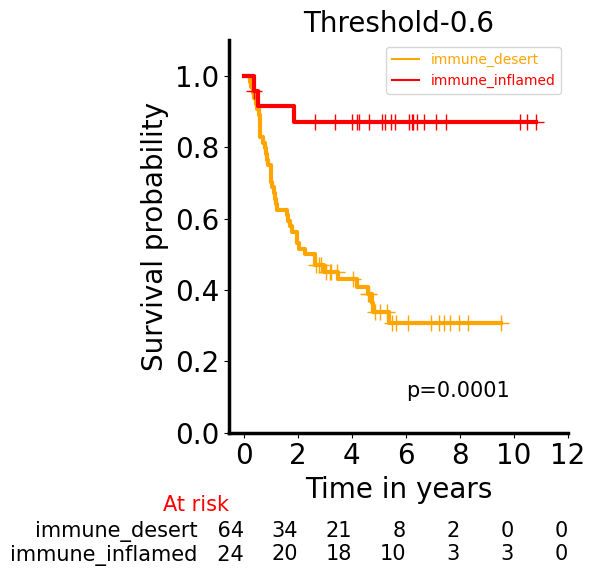

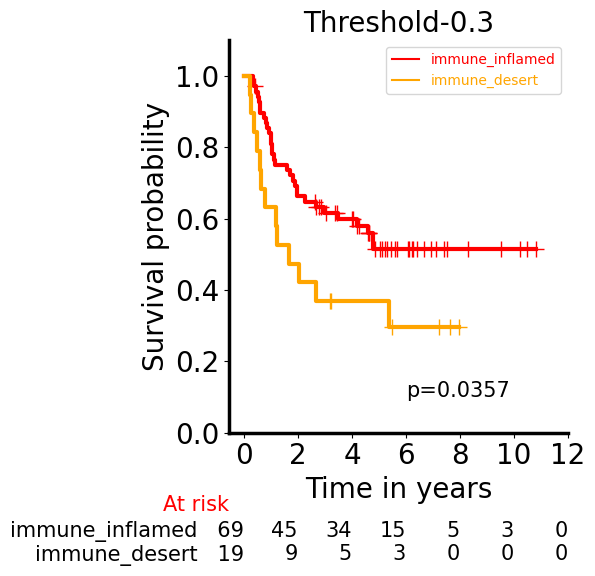

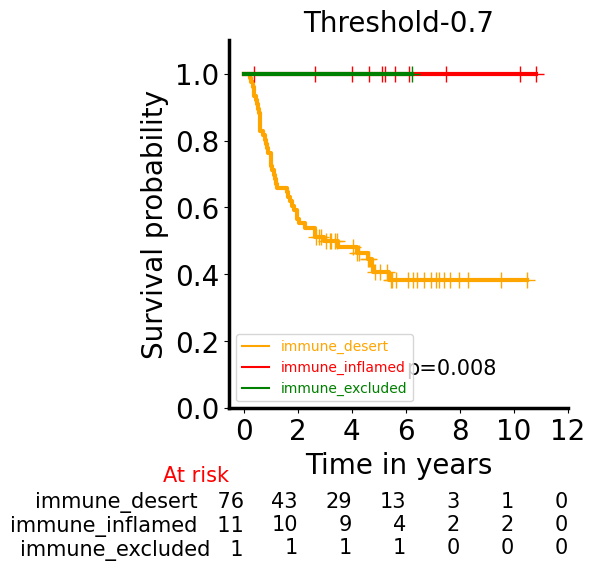

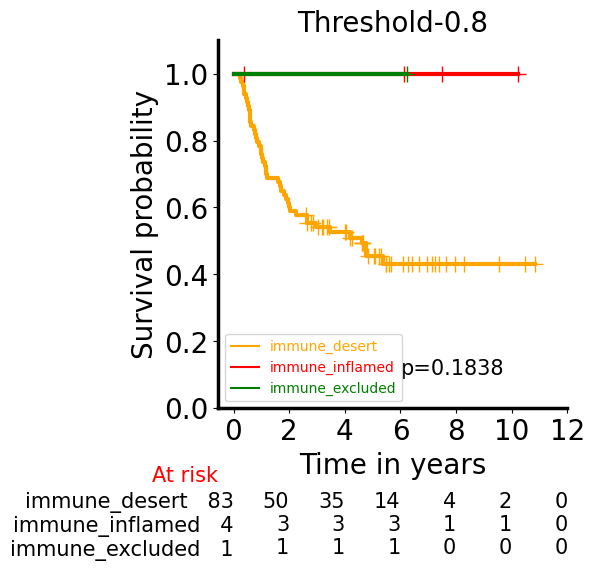

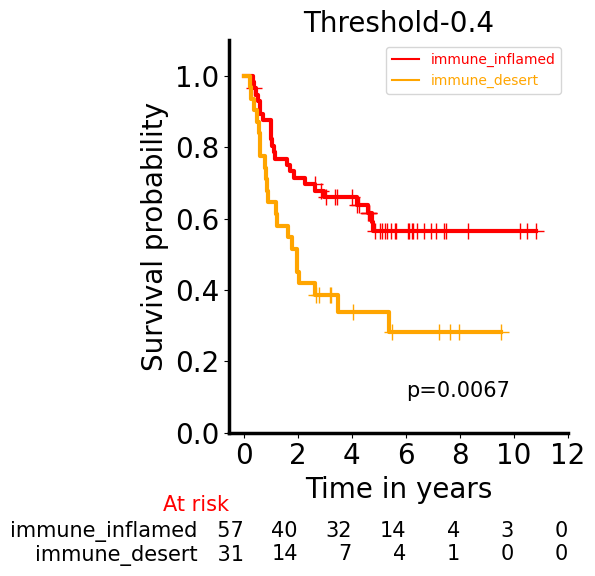

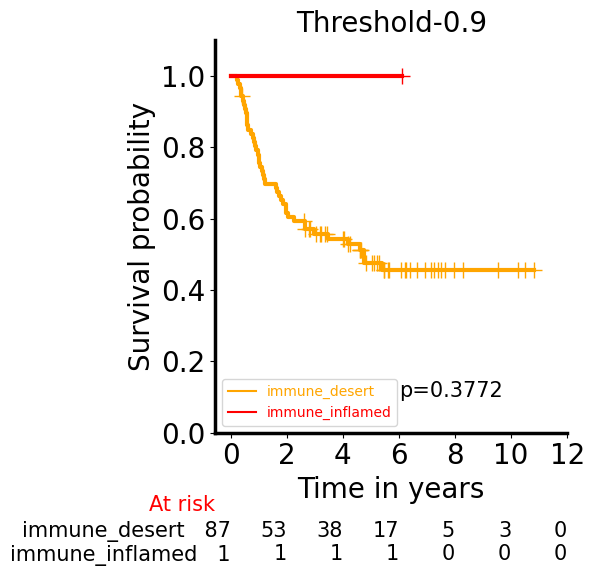

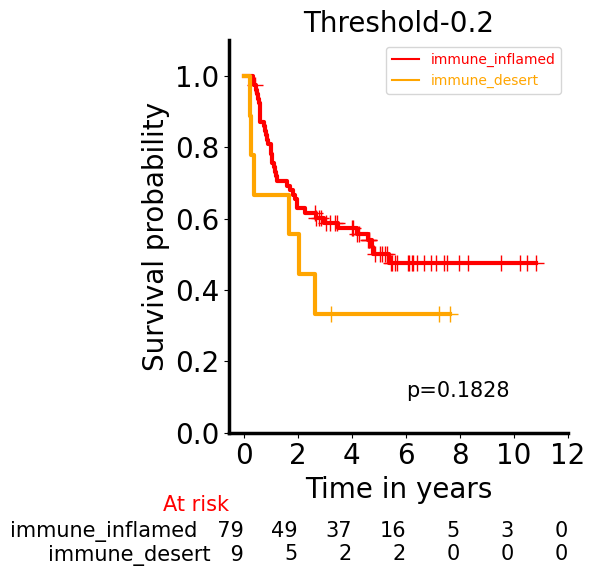

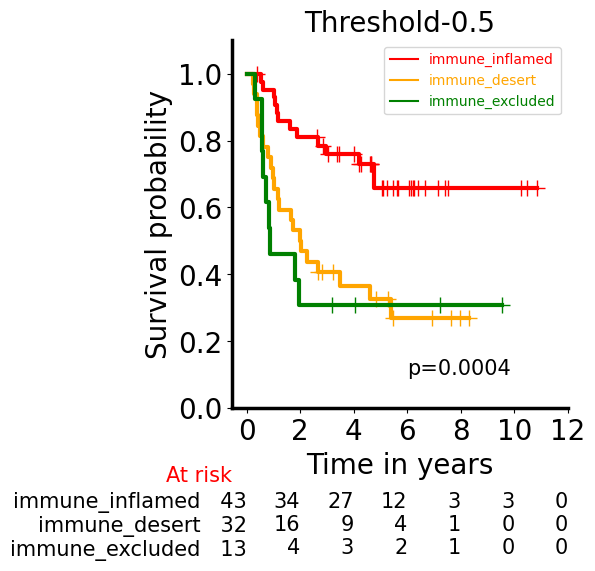

In [25]:
from lifelines import KaplanMeierFitter
import re
from lifelines.statistics import logrank_test,multivariate_logrank_test
path_th_files="../HNSC_Van_abel/immune_ph_diff_thres/"
thre=np.arange(0.2,1,0.1)
for f in os.listdir(path_th_files):
    if ".csv" not in f: continue
    df=pd.read_csv(os.path.join(path_th_files,f))
    km_name=f.split(".csv")[0]
    
    T=df['Years to Progression or Last Follow-up']
    C=df['Case'].astype(float)
    col='Immune_ph'
    colors={"immune_excluded":"g","immune_desert":"orange","immune_inflamed":"red"}


    plt.figure(figsize=(6,6))
    fitters,labels,ax,d_list,e_list,G,colors=plot_km(col,df,T,C,colors) 

    df_rank = pd.DataFrame({
        'durations': d_list,
        'events': e_list,
        'groups': G
    })
    result = multivariate_logrank_test(df_rank['durations'], df_rank['groups'], df_rank['events'])
    result.test_statistic



    sns.despine()
    newxticks = []
    for x in ax.get_xticks():
        if x >= 0:
            newxticks += [x]

    ax.set_xticks(newxticks)

    plt.text(6,.1,'p={}'.format(round(result.p_value,4),'.3f'),fontsize=15)
    for line in plt.gca().lines:
        line.set_linewidth(3.)
    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set(xlabel=None)
    #ax.set(ylabel=None)
    temp = re.findall(r'\d+', f)
    res = list(map(int, temp))
    plt.title(f"Threshold-{round(thre[res[0]],2)}", fontsize=20)

    #ax.legend().set_visible(False)
    ax2=add_at_risk_counts_CUSTOM(fitters,ax=ax,fontsize=15,labels=labels,colors=colors)

    #plt.savefig(f'immune_ph_diff_thres/{km_name}.png')


# Supplementary Figure S2

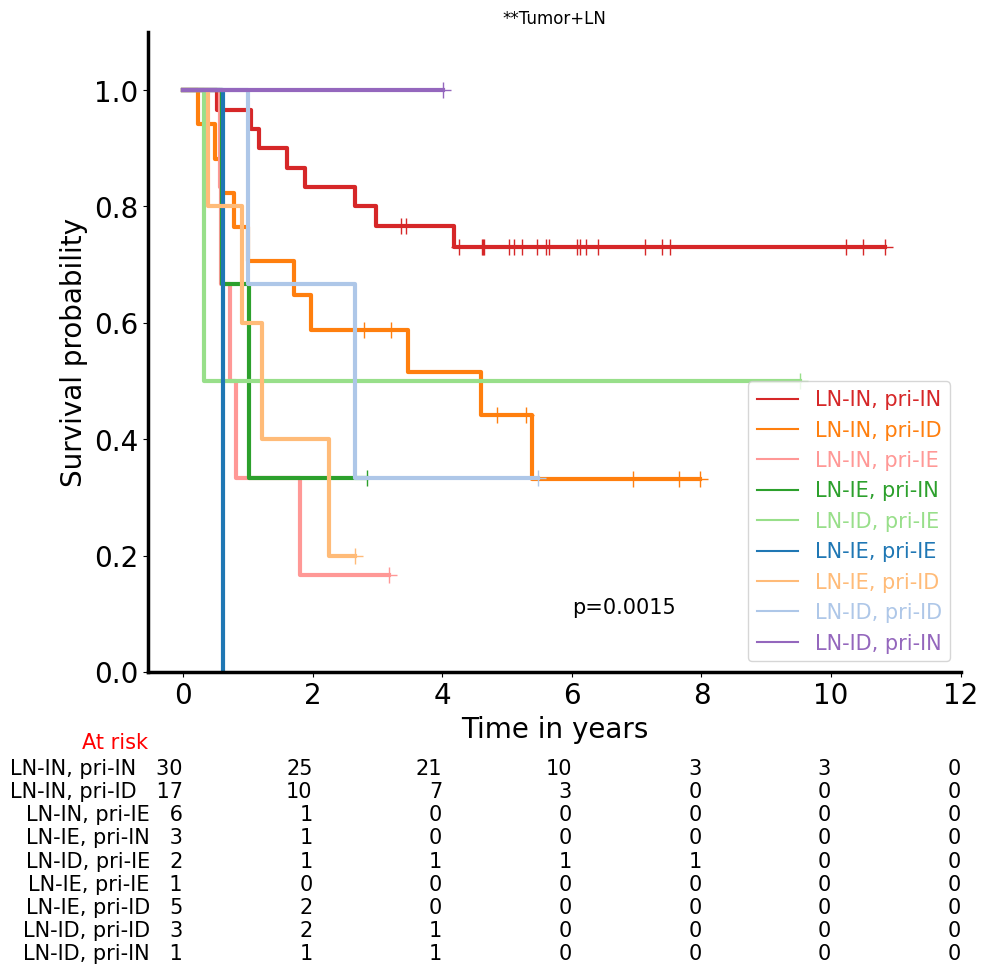

In [24]:
region_1="Tumor"
region_2="LN"
col="Immune_ph"
df_t=pd.read_csv("Immune_pheno_tum_til_density.csv")
df_t.rename(columns={col:"col_tum" },inplace=True)
df_l=pd.read_csv("Immune_pheno_LN_tum_til_density.csv".format(region_2))
df_l.rename(columns={"Immune_ph_LN":"col_LN" }, inplace=True)
df_comb=df_l.merge(df_t[["MRN","col_tum"]],on="MRN", how="left")
df_comb = df_comb.apply(lambda x: x.replace({'immune_inflamed':'IN', 'immune_excluded':'IE','immune_desert':'ID'}, regex=True))
df_comb["LN+prim"]="LN-" + df_comb["col_LN"] + ", pri-" +df_comb["col_tum"]
df_comb.dropna(inplace=True)
df_comb.to_csv(f"combine_LN_primary_csv_files/LN+primary.csv")
colors=None
from matplotlib.pyplot import cm
        #c_values= cm.rainbow(np.linspace(0, 1, len(df[col].unique())))

col_1="LN+prim"
df=df_comb
T=df['Years to Progression or Last Follow-up']
C=df['Case'].astype(float)

c_values=plt.cm.tab20(range(0,len(df[col_1].unique())))
#import random
np.random.seed(3)
np.random.shuffle(c_values)
colors=dict(zip(df[col_1].unique(),c_values))

plt.figure(figsize=(10,10))
fitters,labels,ax,d_list,e_list,G,colors=plot_km(col_1,df,T,C,colors) 

df_rank = pd.DataFrame({
    'durations': d_list,
    'events': e_list,
    'groups': G
})
result = multivariate_logrank_test(df_rank['durations'], df_rank['groups'], df_rank['events'])
result.test_statistic
sns.despine()
newxticks = []
for x in ax.get_xticks():
    if x >= 0:
        newxticks += [x]

ax.set_xticks(newxticks)
if result.p_value< 0.05:
    plt.title('**{}+{}'.format(region_1,region_2))
else:
    plt.title('{}+{}'.format(region_1,region_2))
plt.text(6,.1,'p={}'.format(round(result.p_value,4)),fontsize=15)
ax.legend(labelcolor='linecolor',fontsize=15)
for line in plt.gca().lines:
    line.set_linewidth(3.)
#ax.legend().set_visible(False)
ax2=add_at_risk_counts_CUSTOM(fitters,ax=ax,fontsize=15,labels=labels,colors=colors)
#plt.savefig('combine_LN_primary_csv_files/KM_{}+{}.png'.format(region_1,region_2))



# Chi-squares text case vs control Supplementary Figure S3(A,B)

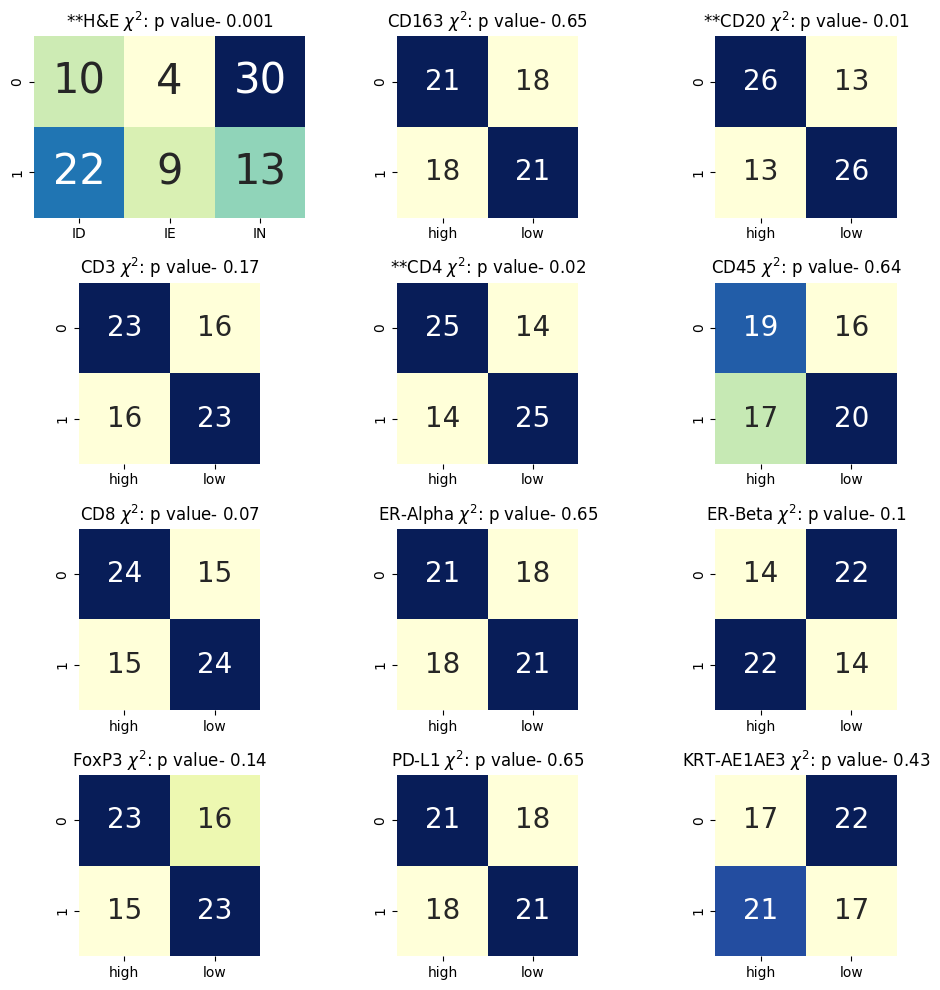

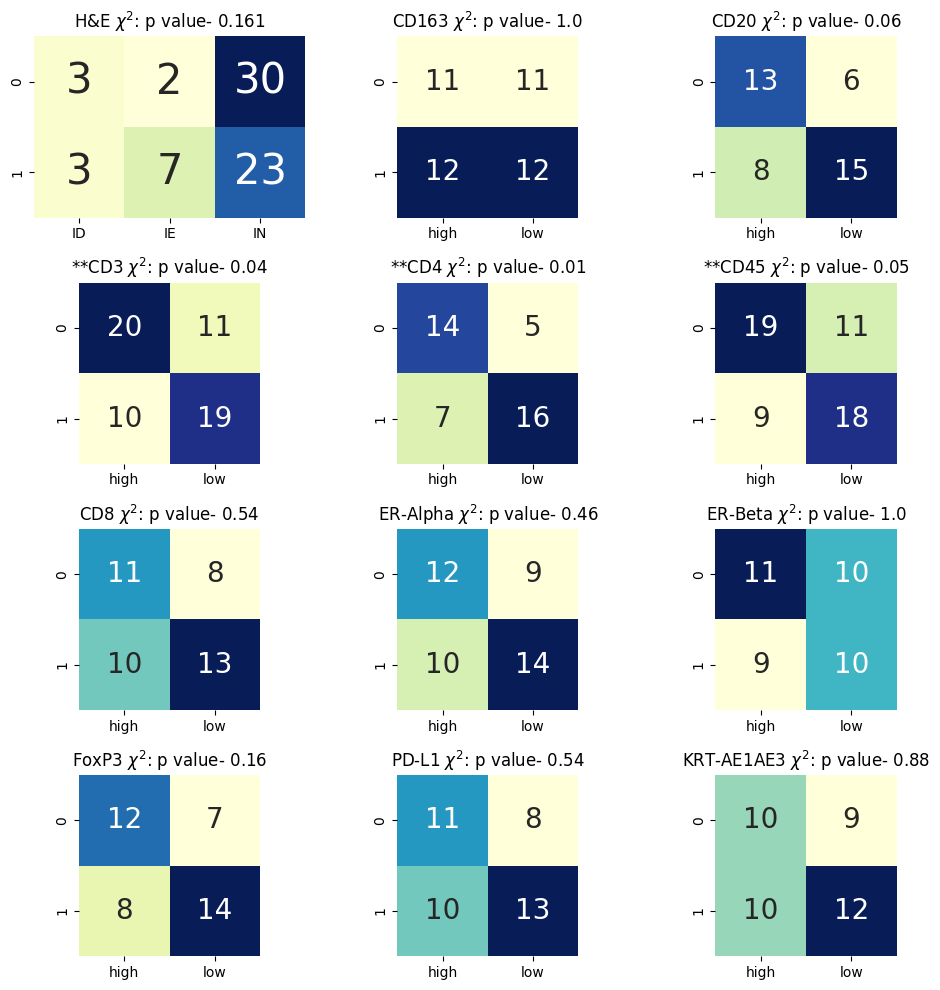

In [29]:
from scipy.stats import chi2_contingency
import seaborn as sns

sns.set(font_scale=2)
plt.rcParams.update({'font.size': 22})
plt.rcParams.update(plt.rcParamsDefault)
def chi_sq_test_case_control(region):
    marker_list=["CD163","CD20","CD3","CD4","CD45","CD8","ER-Alpha","ER-Beta","FoxP3","PD-L1","KRT-AE1AE3"]
    mode="median"
    f,axes=plt.subplots(4,3,figsize=(10,10))
    axes=axes.ravel()
    if region=="Tumor":
        path="Immune_pheno_tum_til_density.csv"
        df=pd.read_csv(path)
        contigency=pd.crosstab(df.Case,df.Immune_ph)
    else:
        path="Immune_pheno_LN_tum_til_density.csv"
        df=pd.read_csv(path)
        contigency=pd.crosstab(df.Case,df.Immune_ph_LN)
    
    x_label=["ID", "IE","IN"]
    c, p, dof, expected = chi2_contingency(contigency)
    sns.heatmap(contigency, annot=True, cmap="YlGnBu",xticklabels=x_label,ax=axes[0],cbar=False,annot_kws={"fontsize":30})
    if p<0.05:
        axes[0].title.set_text("**H&E $\u03C7^2$: p value- {}".format(round(p,3)))
    else:
        axes[0].title.set_text("H&E $\u03C7^2$: p value- {}".format(round(p,3)))

    for l,i in enumerate(marker_list):
        #print(i)
        col_name=f"{i}_{mode}_binary"
        df=pd.read_csv(f"HE_IHC_comb_IN_{region}/" + i + "_quant_patient{}.csv".format(region))
        #print(df.columns)
        #print(df.col_name)
        contigency=pd.crosstab(df.Case,df[col_name])
        c, p, dof, expected = chi2_contingency(contigency)
        sns.heatmap(contigency, annot=True, cmap="YlGnBu",ax=axes[l+1],cbar=False,annot_kws={"fontsize":f_size})
        if p<0.05:
            axes[l+1].title.set_text("**{} $\u03C7^2$: p value- {}".format(i,round(p,2)))
        else:
            axes[l+1].title.set_text("{} $\u03C7^2$: p value- {}".format(i,round(p,2)))
    for ax in axes:
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()
#plt.savefig(f"case-control-chi-sq/{region}_chi-sq.png")
regions=["Tumor","LN"]
for region in regions:
    chi_sq_test_case_control(region)




# Supplementary Figure S4 

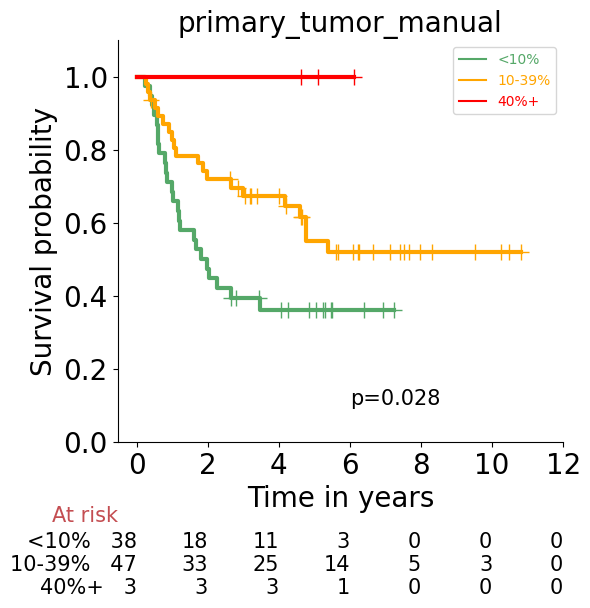

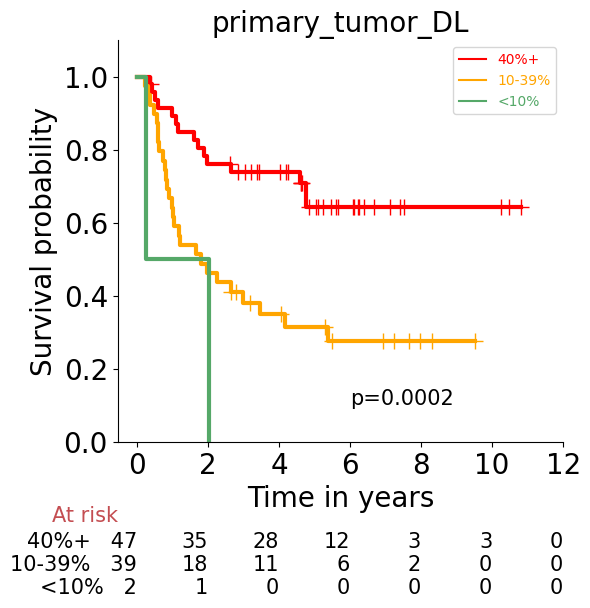

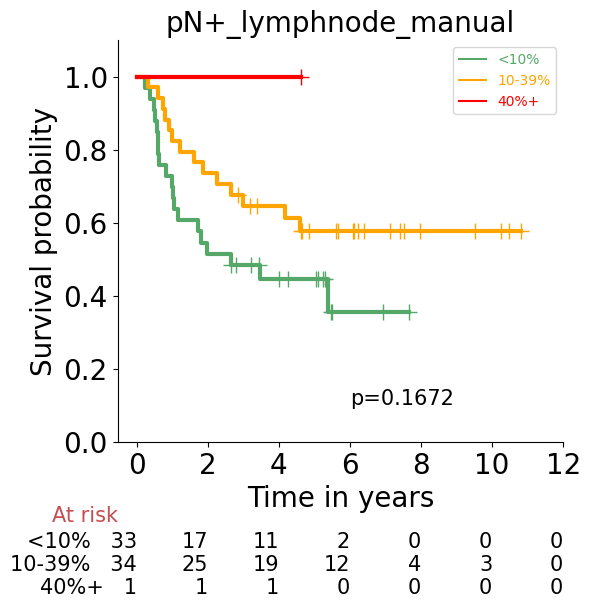

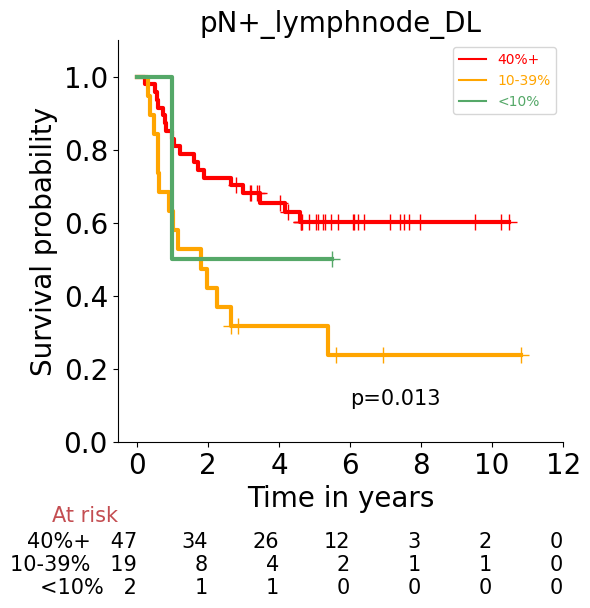

In [31]:
#following function produces KM plots based on H&E subtypes
def plot_km_region_manual_DL_subtypes(region,anno):
    ''' region: options primary_tumor or pN+_lymphnode 
        anno: options manual or DL'''
    if region=="primary_tumor":
        path="Immune_pheno_tum_til_density.csv"
        df=pd.read_csv(path)  
        T=df['Years to Progression or Last Follow-up']
        C=df['Case'].astype(float)
        if anno=="manual":
            col="Primary Tumor Tumoral TILs Density"
        else:
            col="til_dens_cat"
    else:
        path="Immune_pheno_LN_tum_til_density.csv"
        df=pd.read_csv(path)   
        T=df['Years to Progression or Last Follow-up']
        C=df['Case'].astype(float)
        if anno=="manual":
            col="Lymph Node Tumoral TILs Density"
        else:
            col="til_dens_cat"

    colors={"<10%":"g","10-39%":"orange","40%+":"red"}
    plt.figure(figsize=(6,6))
    fitters,labels,ax,d_list,e_list,G,colors=plot_km(col,df,T,C,colors) 

    df_rank = pd.DataFrame({
        'durations': d_list,
        'events': e_list,
        'groups': G
    })
    result = multivariate_logrank_test(df_rank['durations'], df_rank['groups'], df_rank['events'])
    result.test_statistic



    sns.despine()
    newxticks = []
    for x in ax.get_xticks():
        if x >= 0:
            newxticks += [x]

    ax.set_xticks(newxticks)

    plt.text(6,.1,'p={}'.format(round(result.p_value,4),'.3f'),fontsize=15)
    for line in plt.gca().lines:
        line.set_linewidth(3.)
    ax2=add_at_risk_counts_CUSTOM(fitters,ax=ax,fontsize=15,labels=labels,colors=colors)
    plt.title(f'{region}_{anno}', fontsize=20)
    plt.show()
        
regions=["primary_tumor","pN+_lymphnode"]
annotations=["manual","DL"]

for region in regions:
    for anno in annotations:
        plot_km_region_manual_DL_subtypes(region,anno)
    

# KM plots for IHC marker alone, Supplementary Figure S5

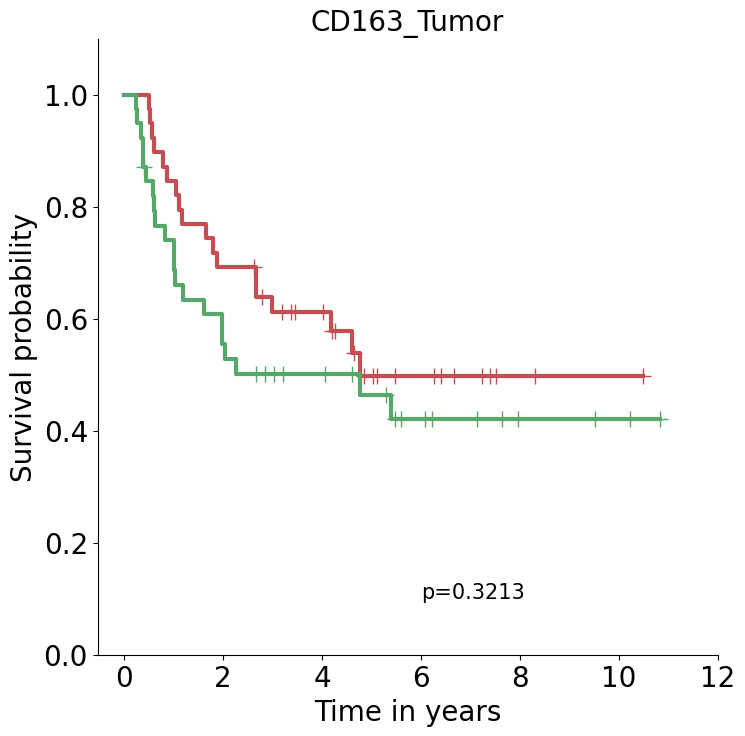

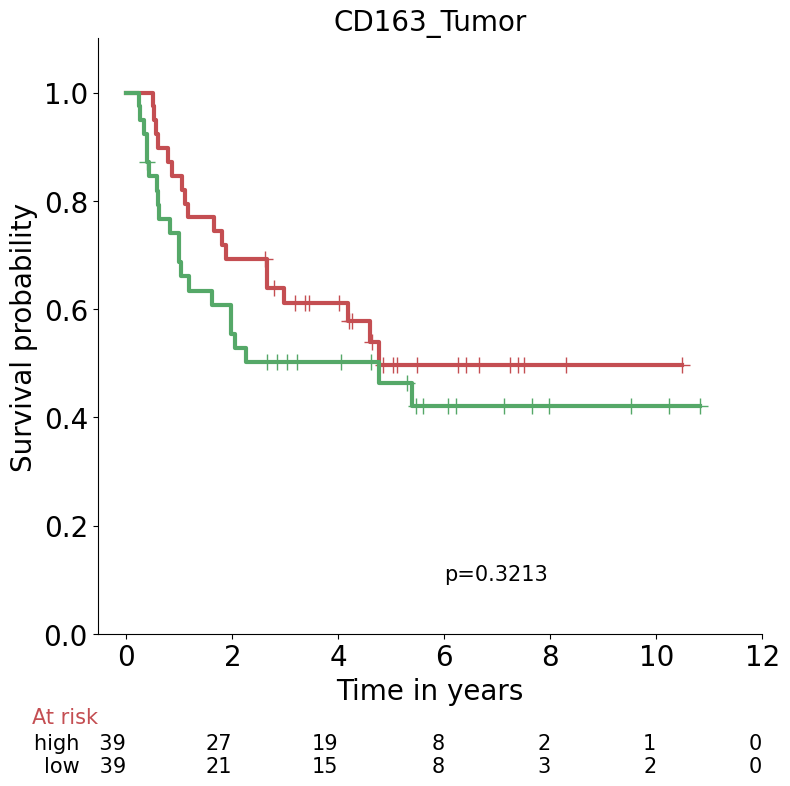

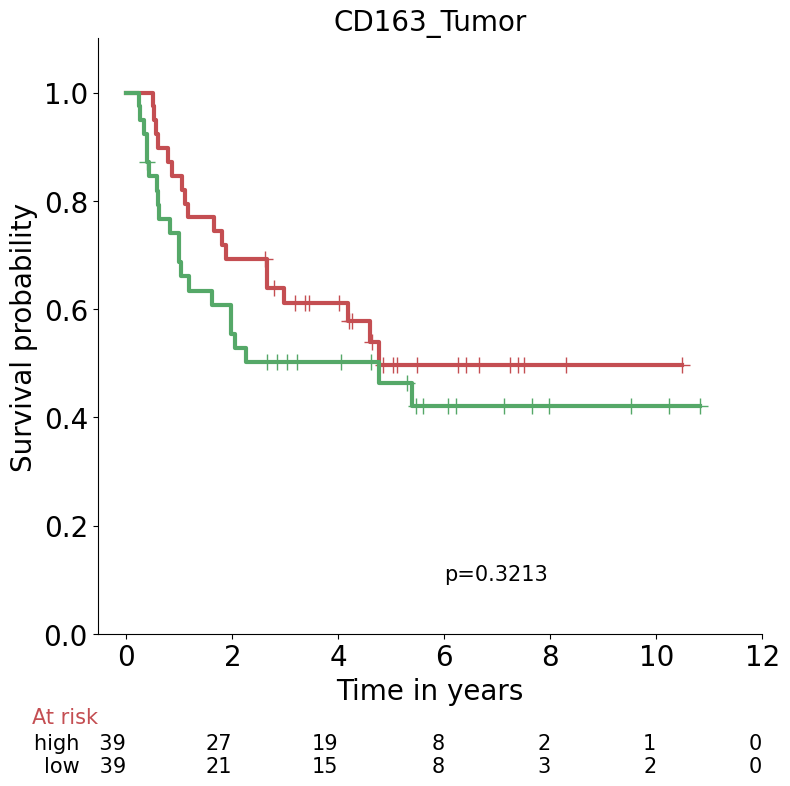

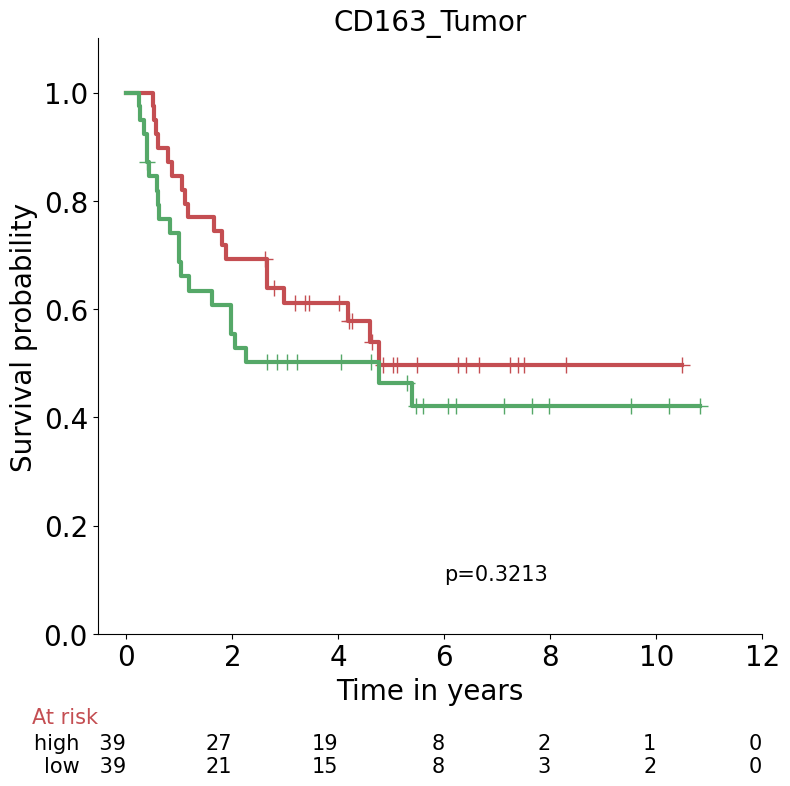

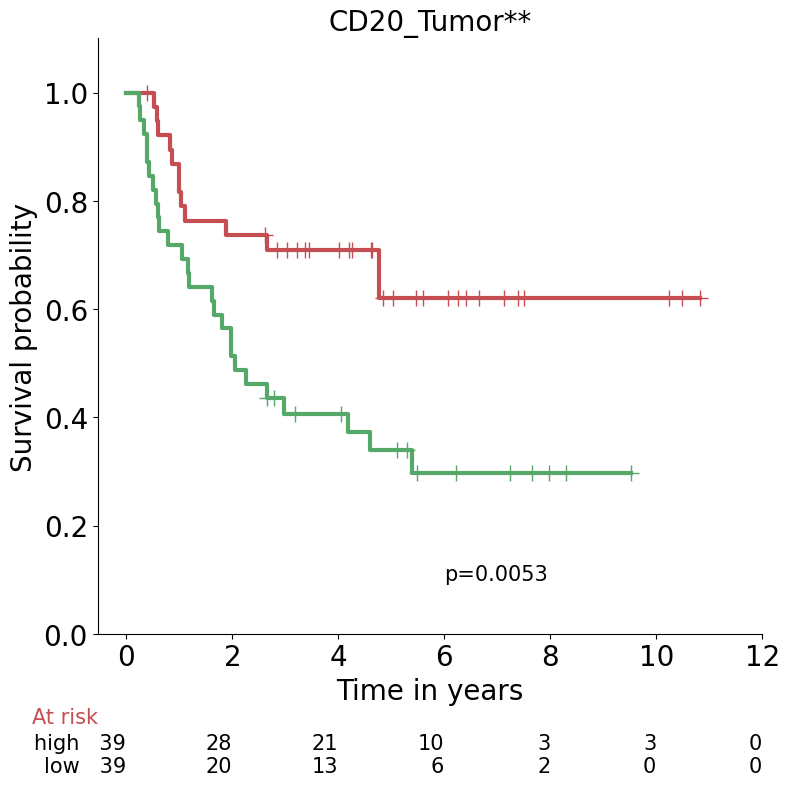

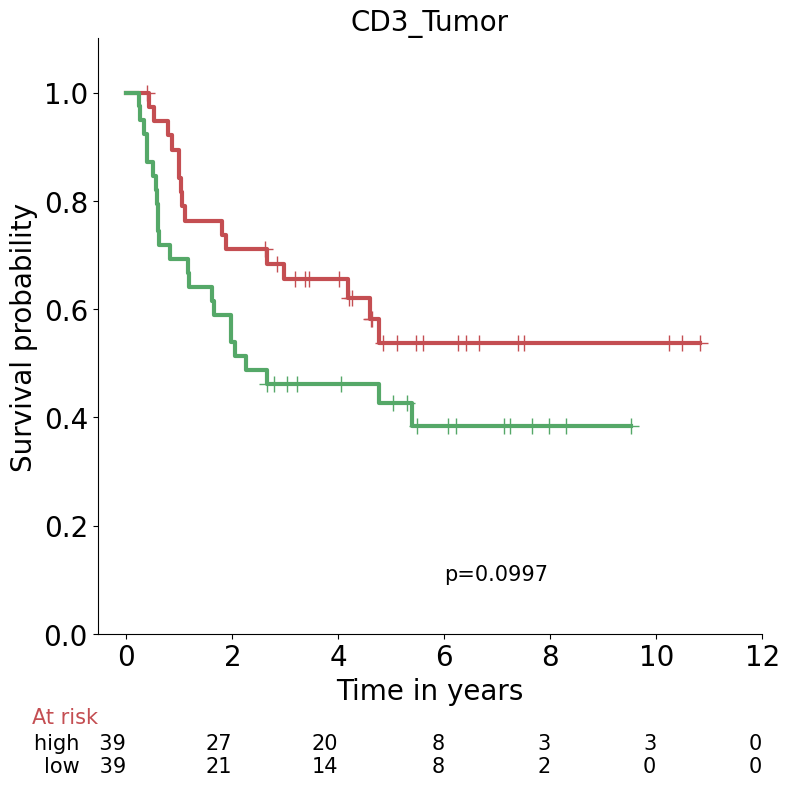

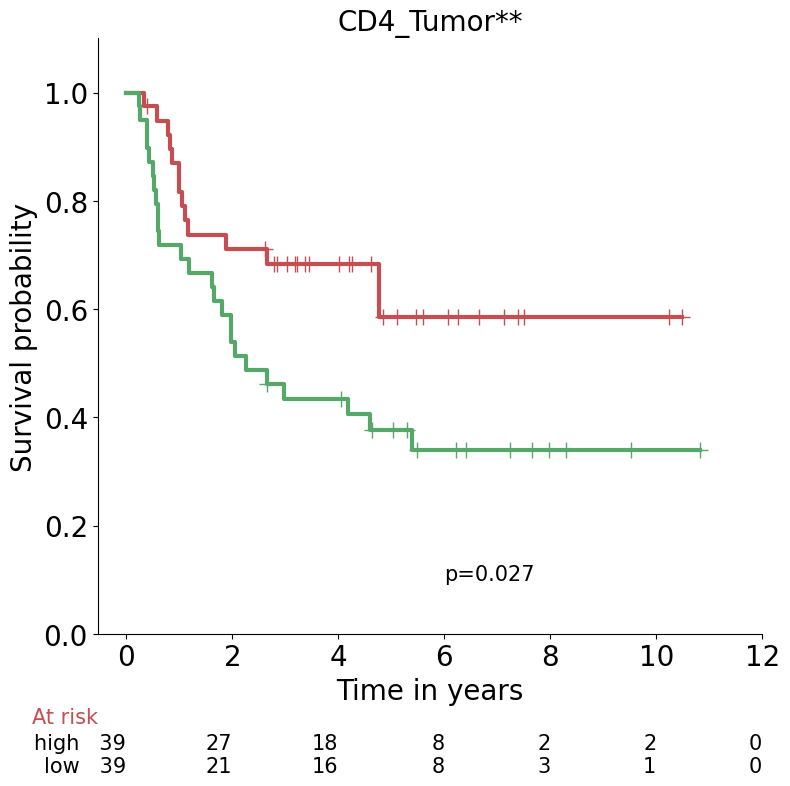

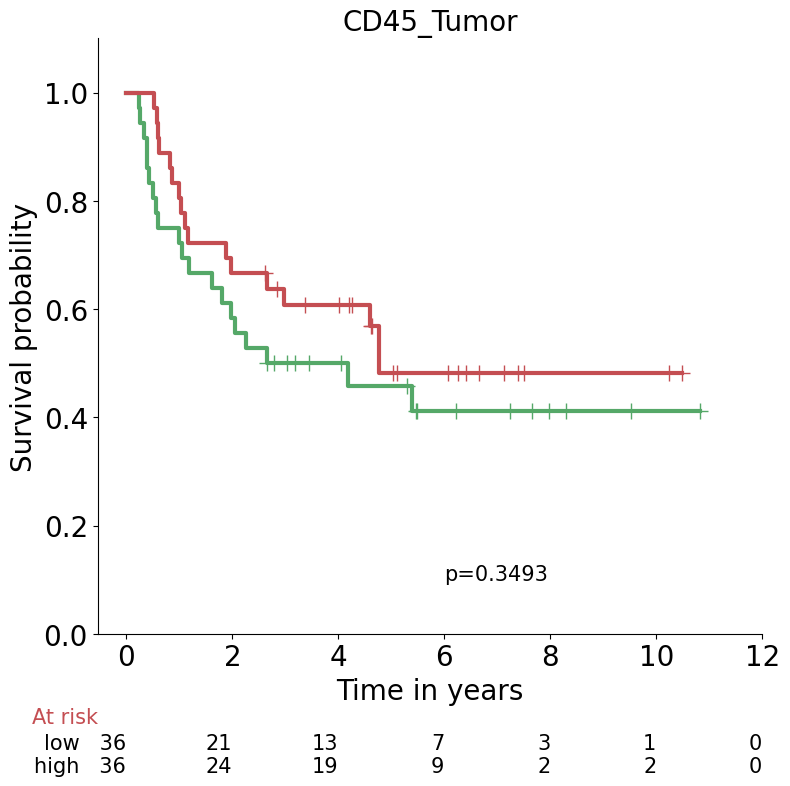

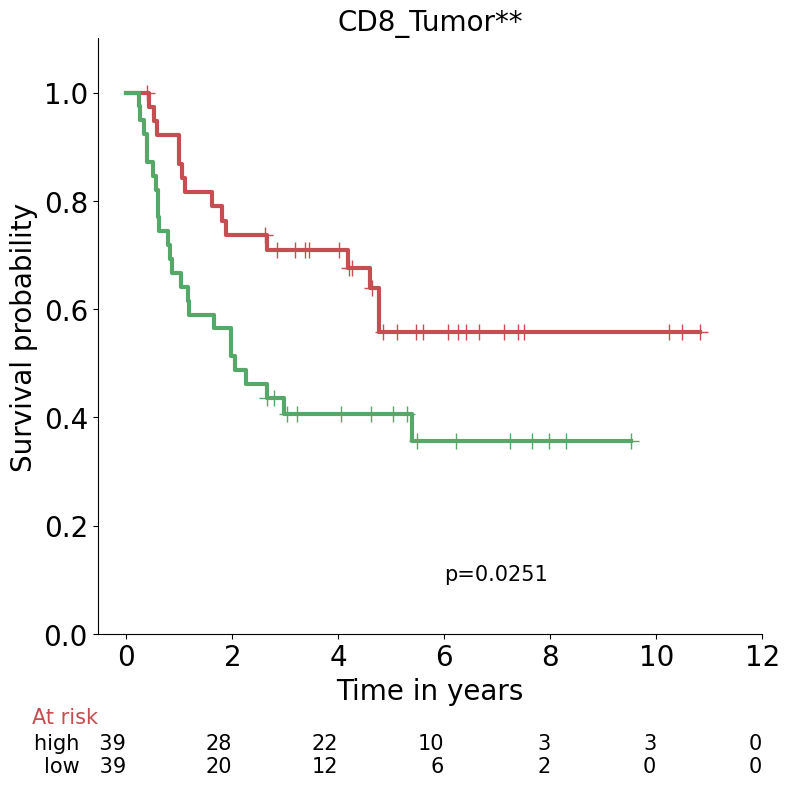

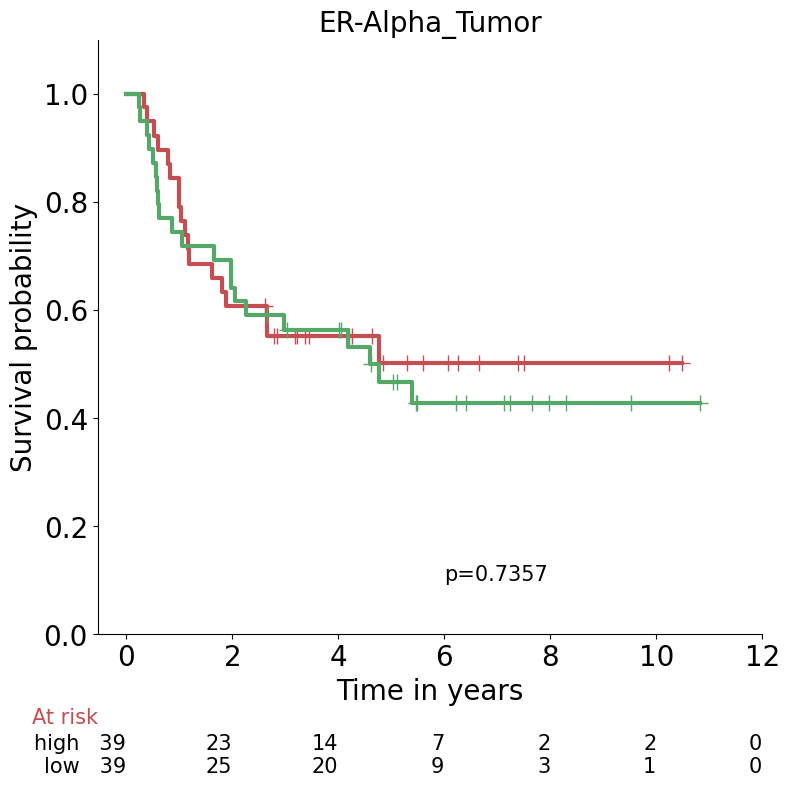

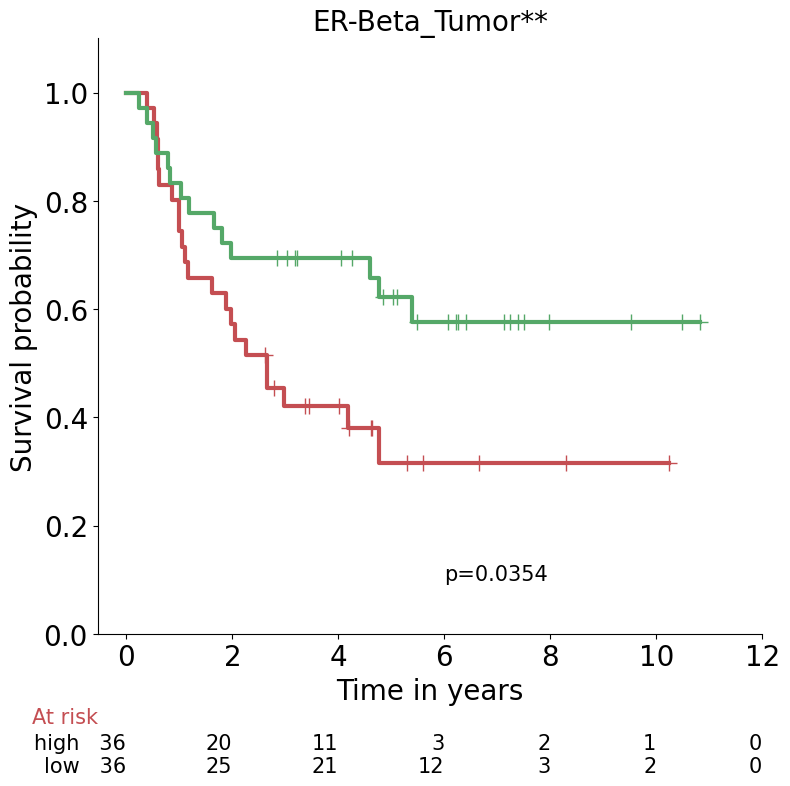

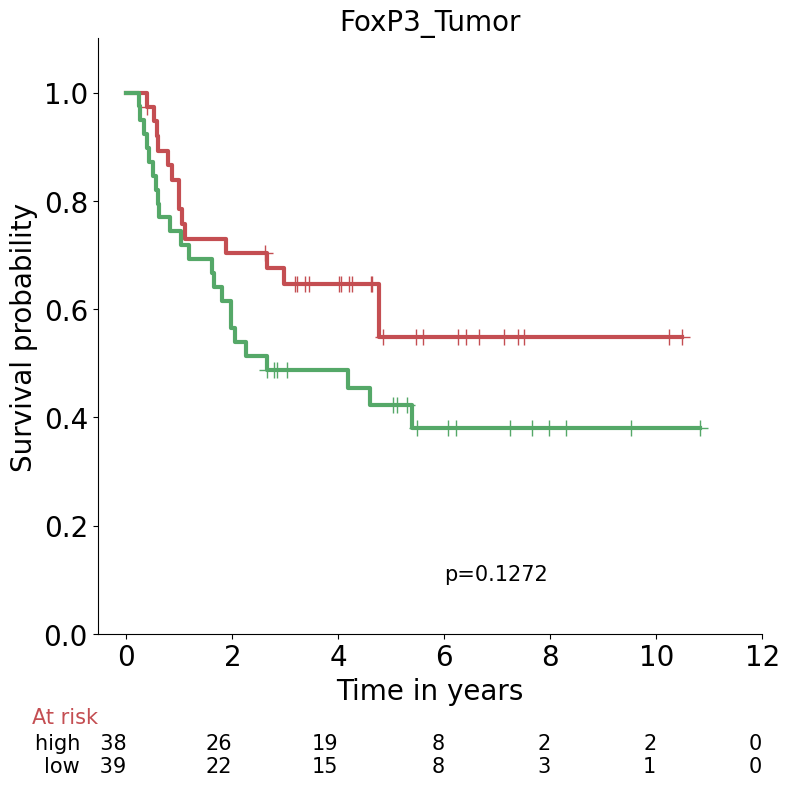

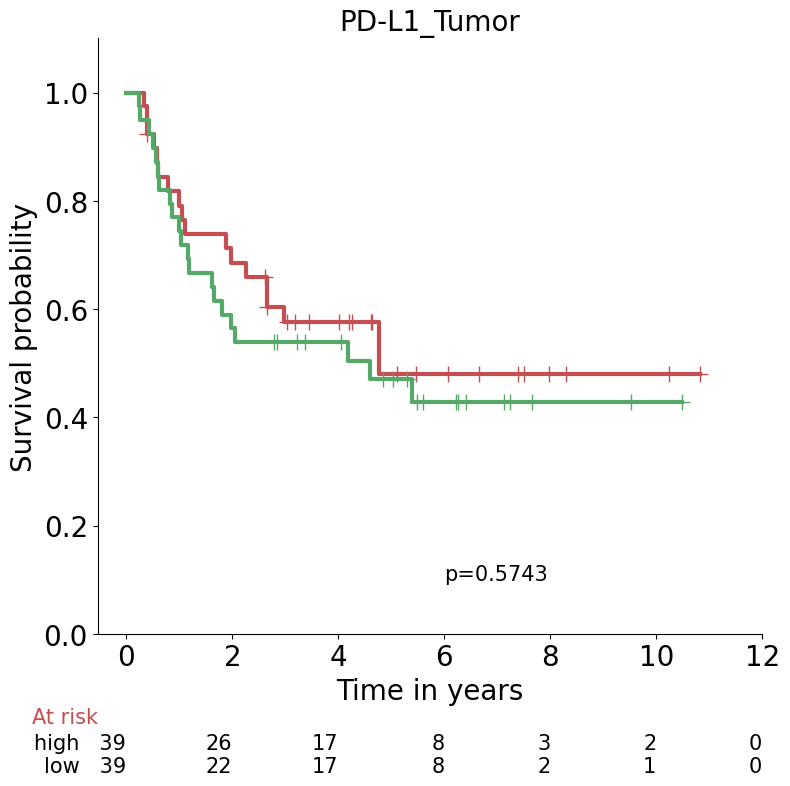

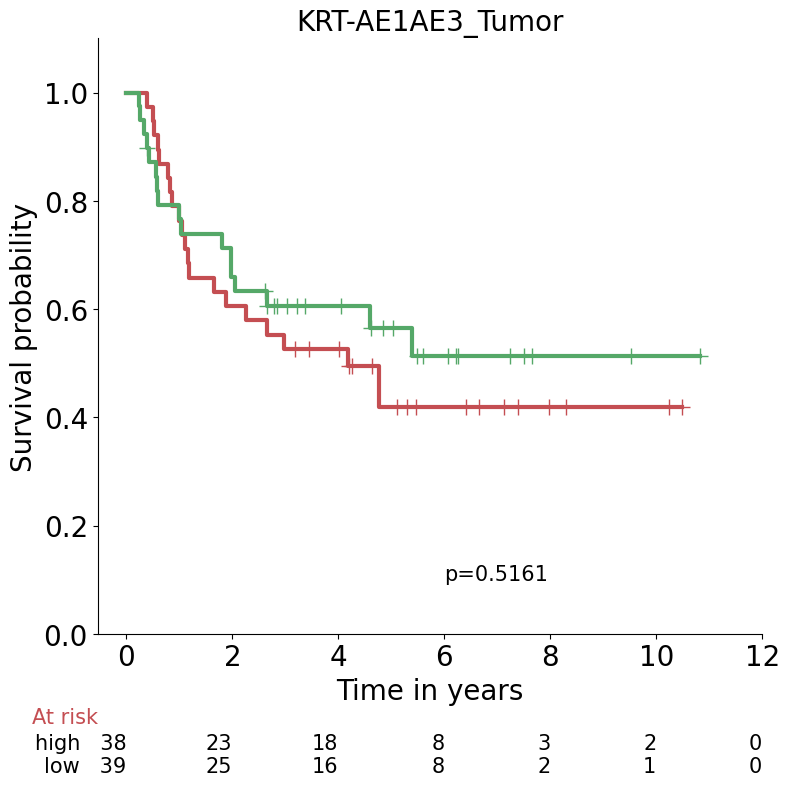

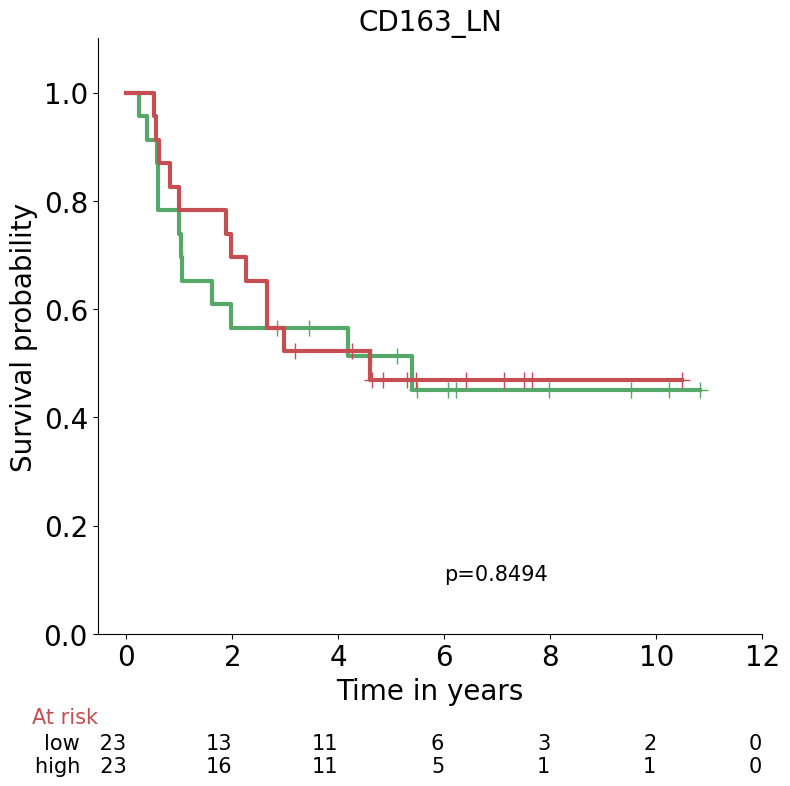

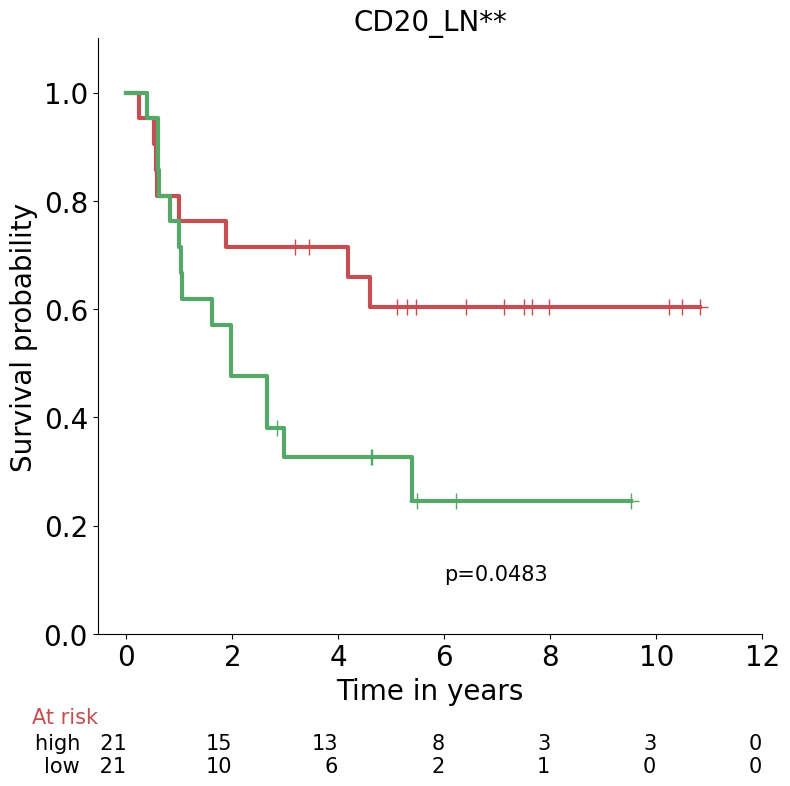

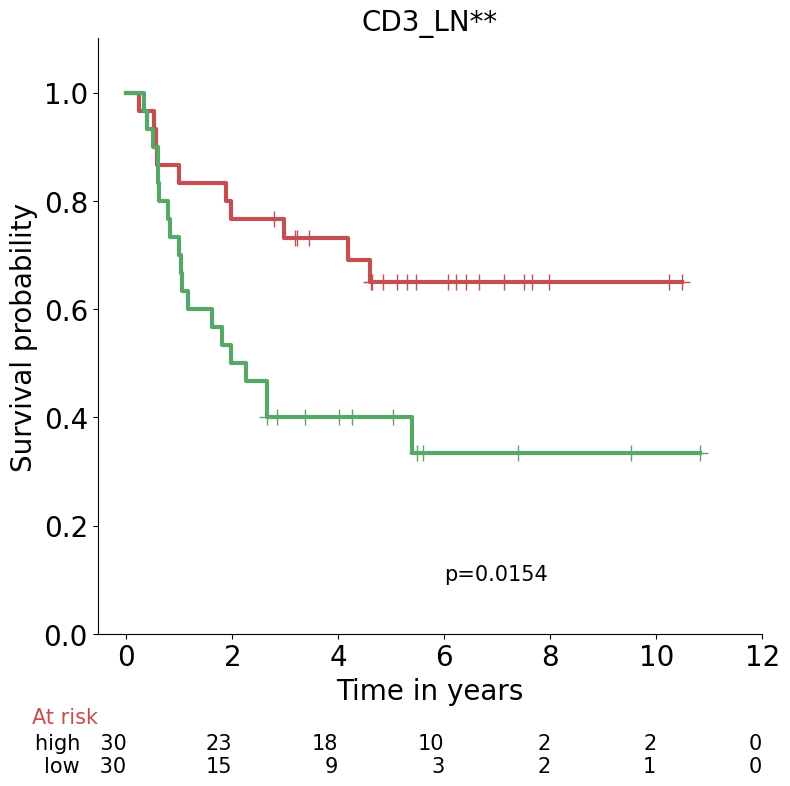

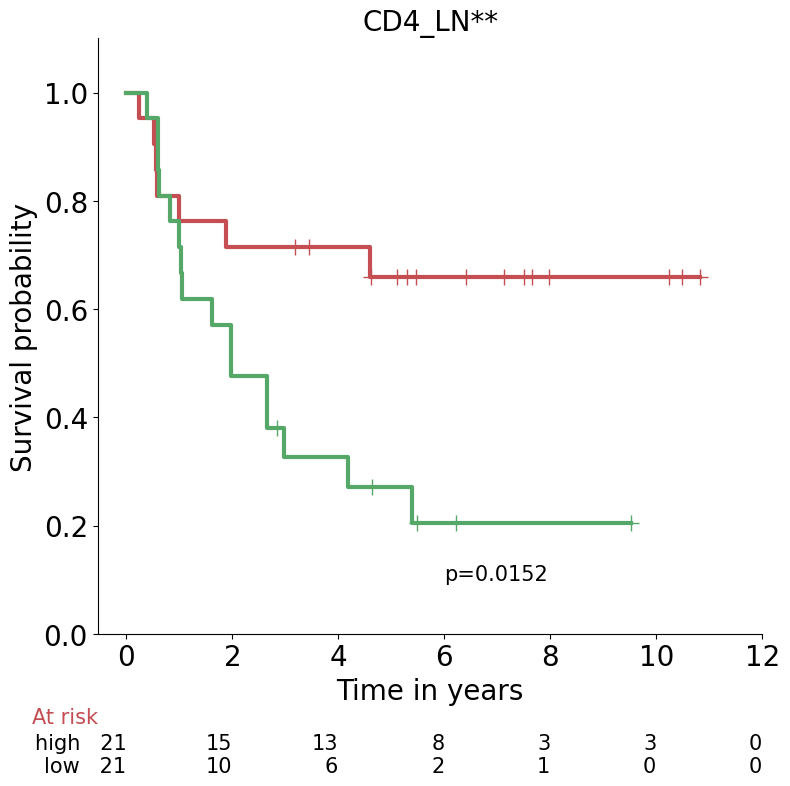

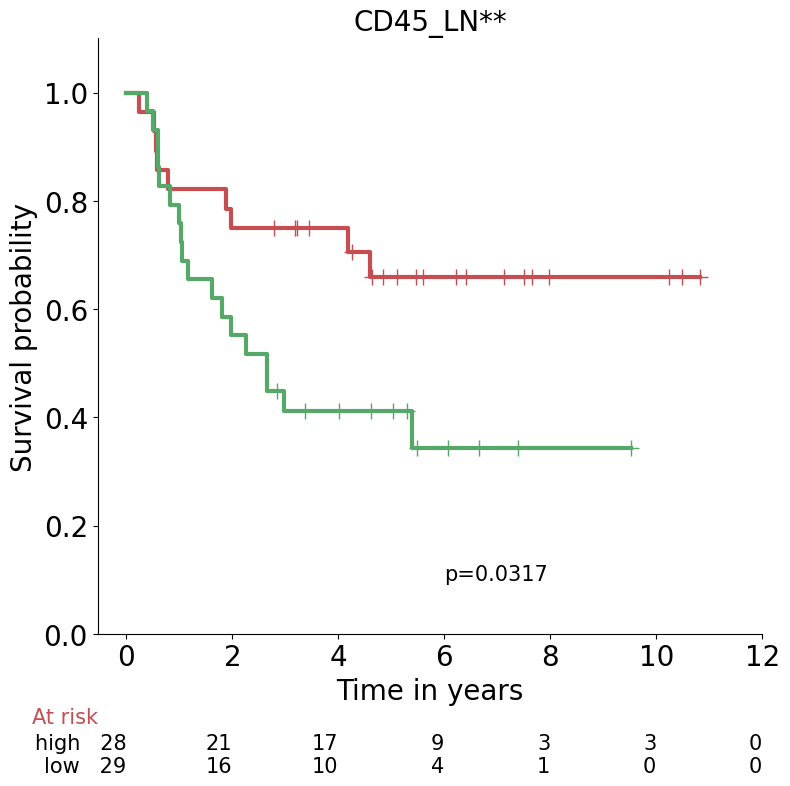

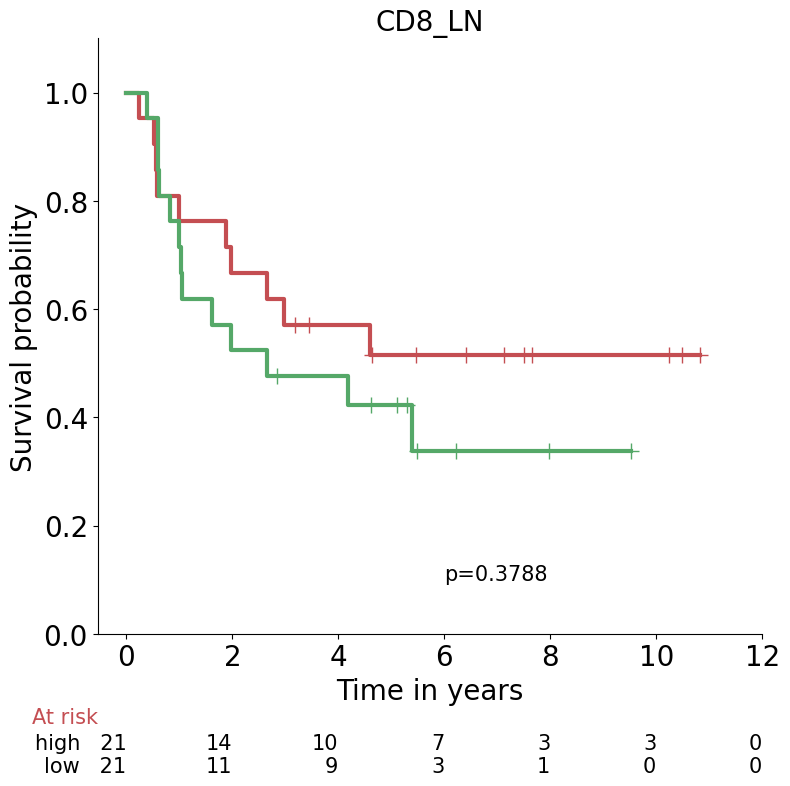

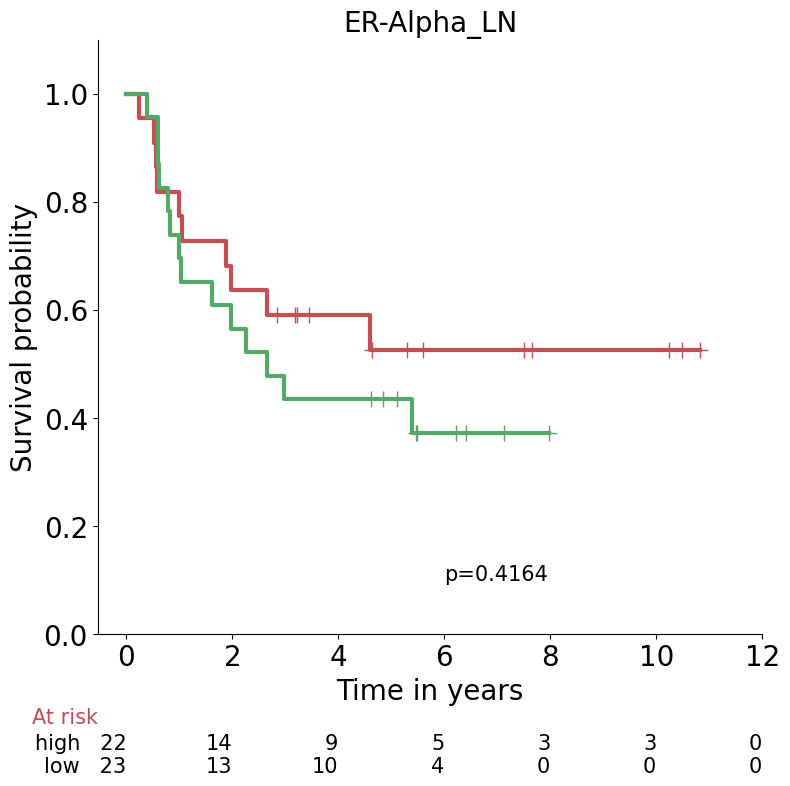

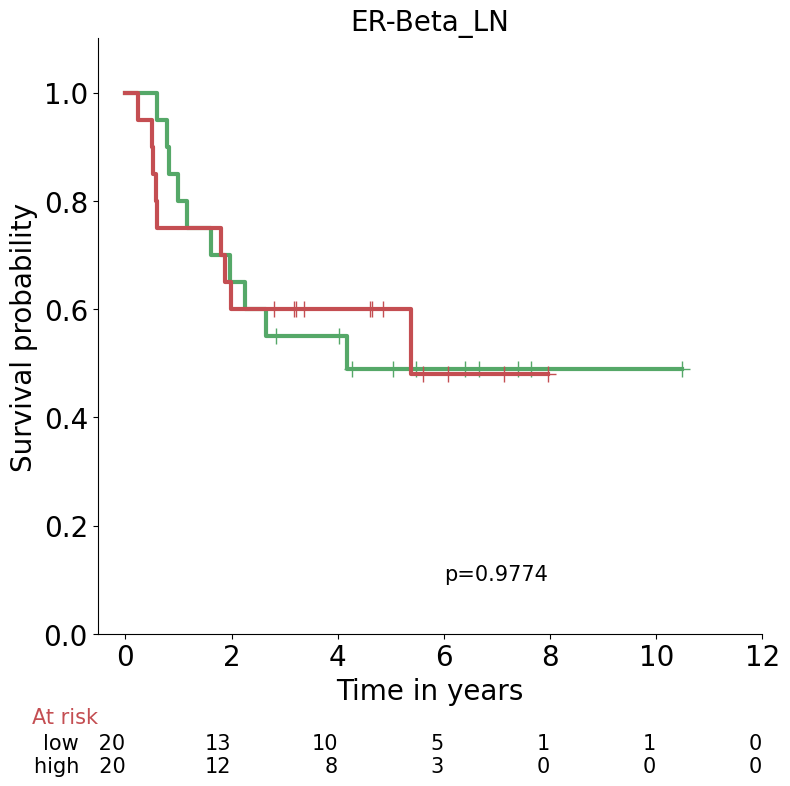

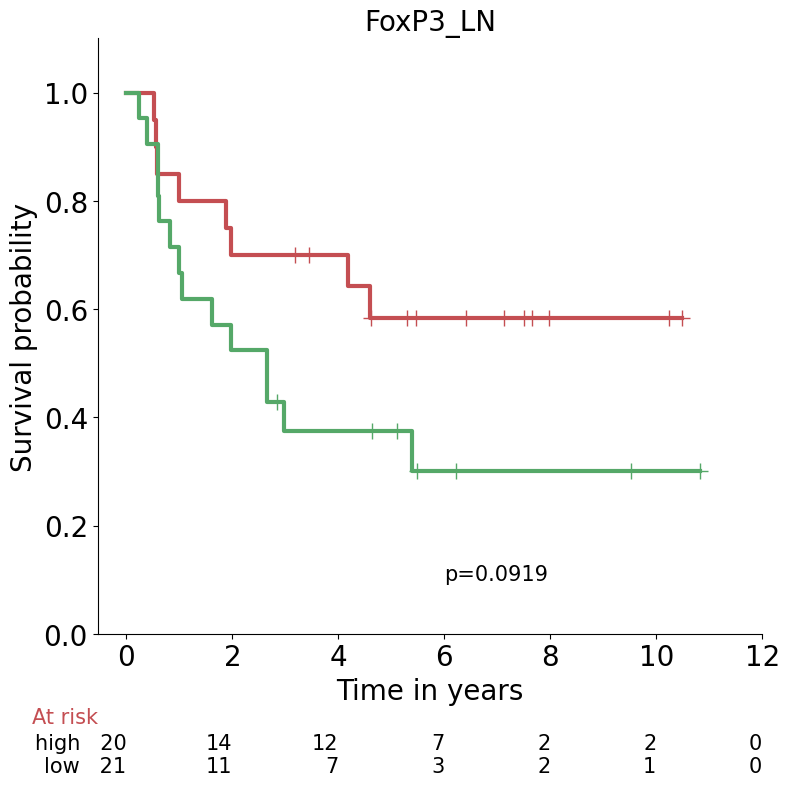

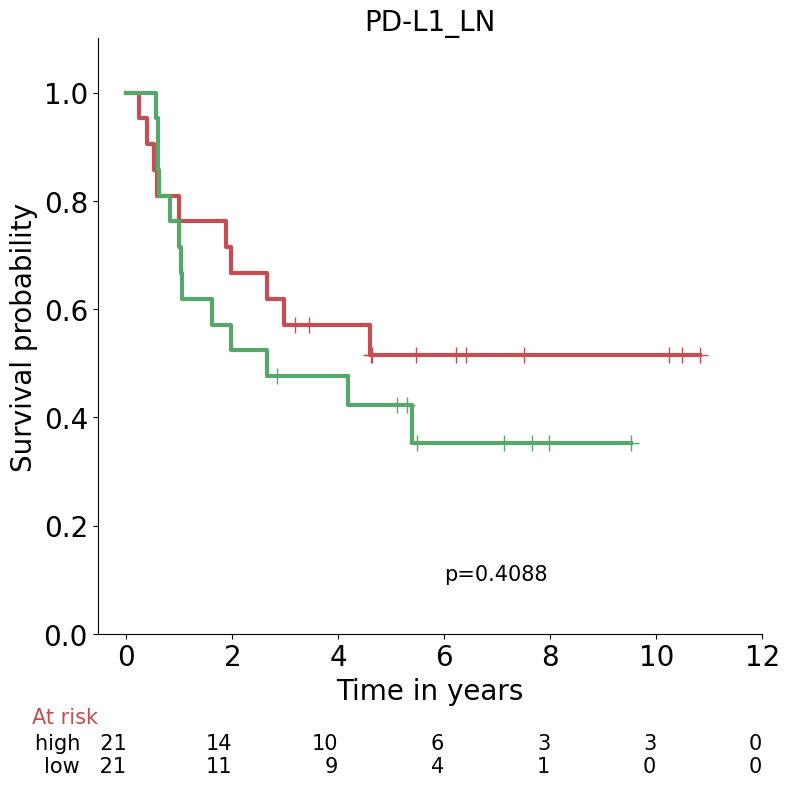

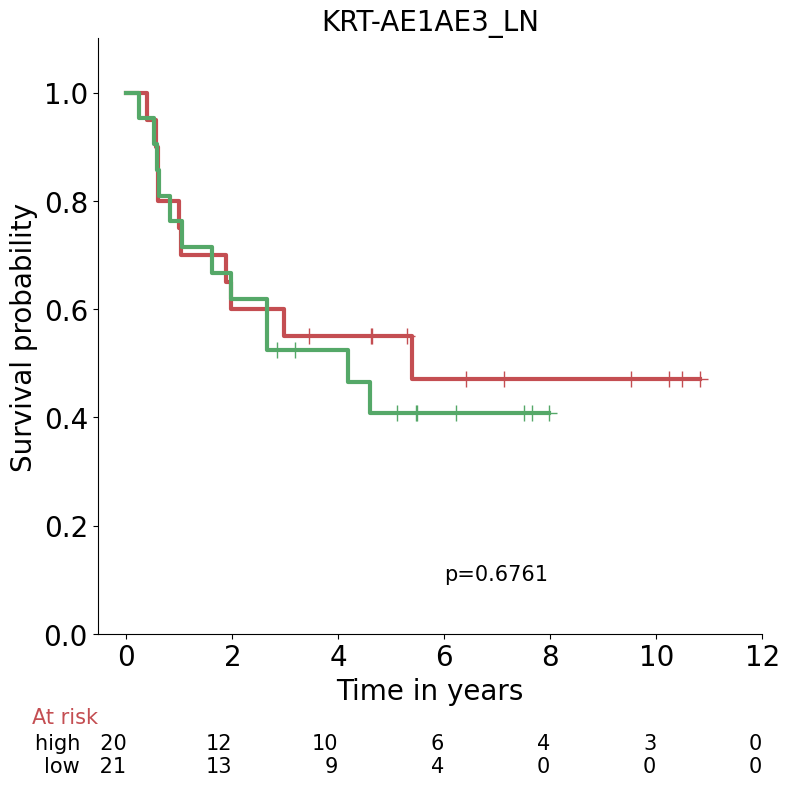

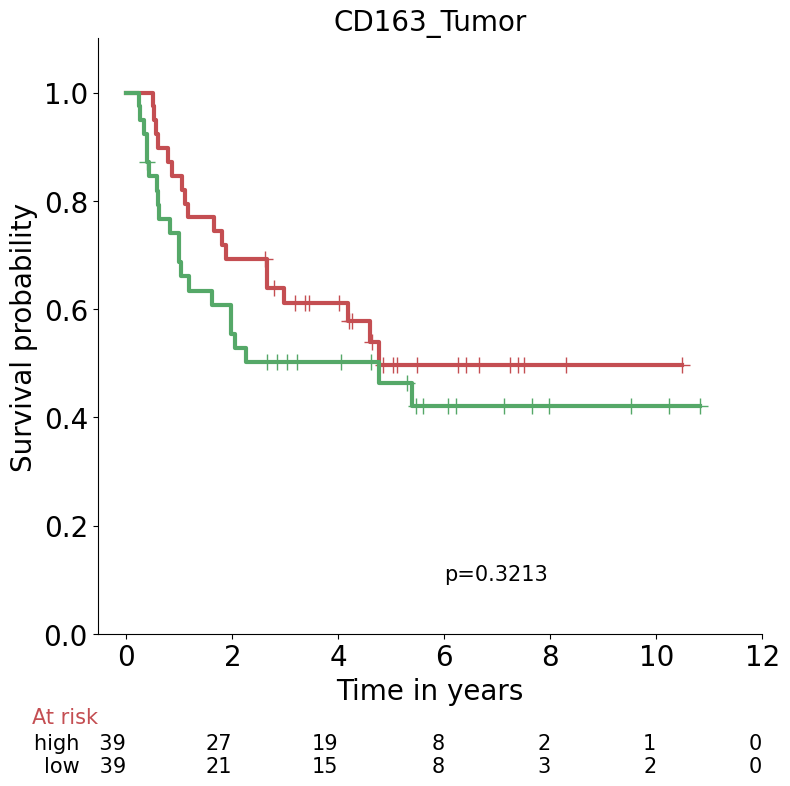

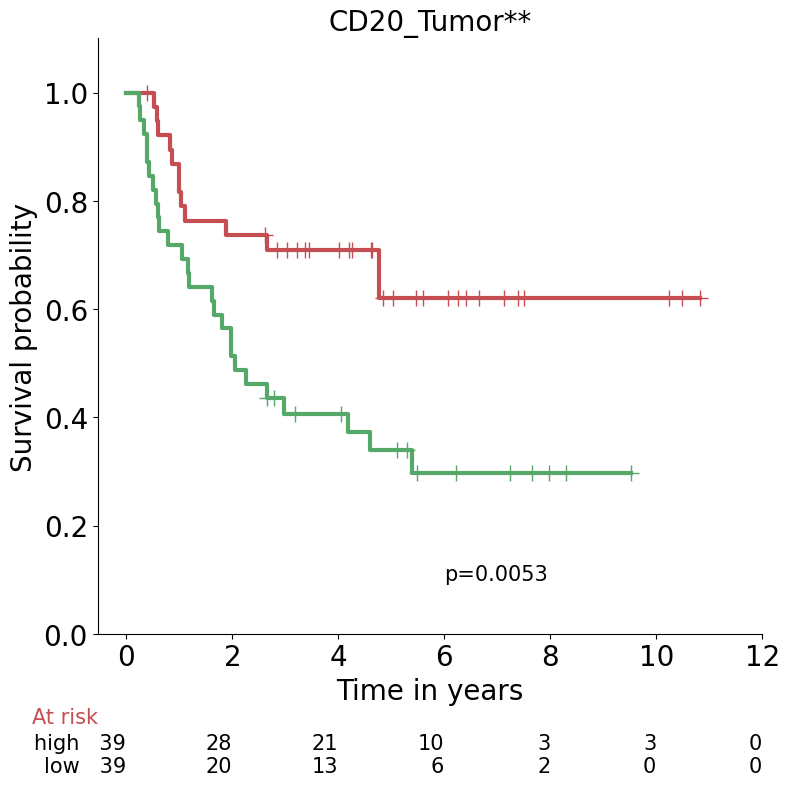

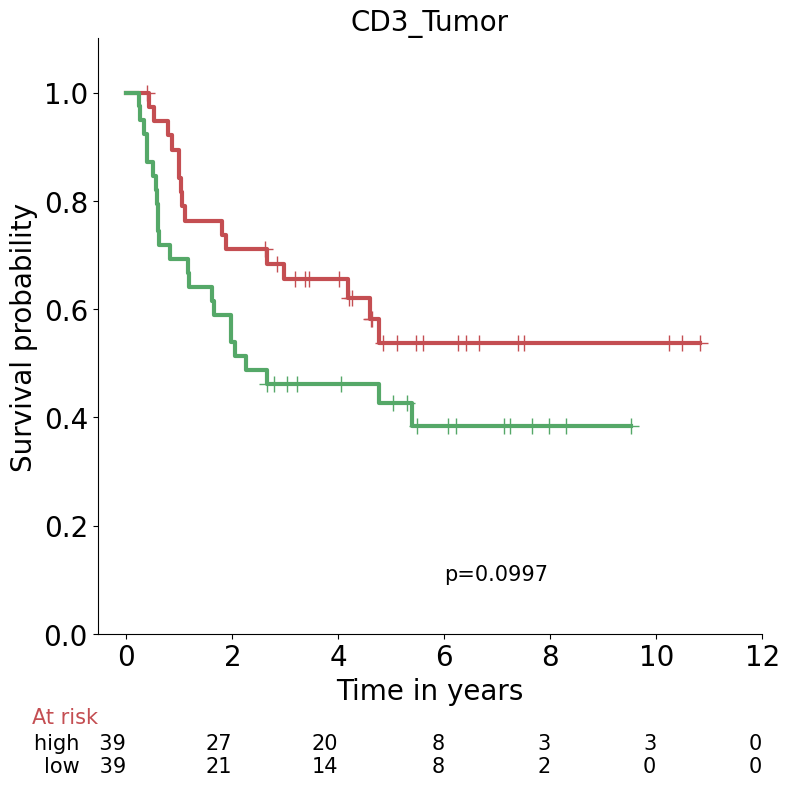

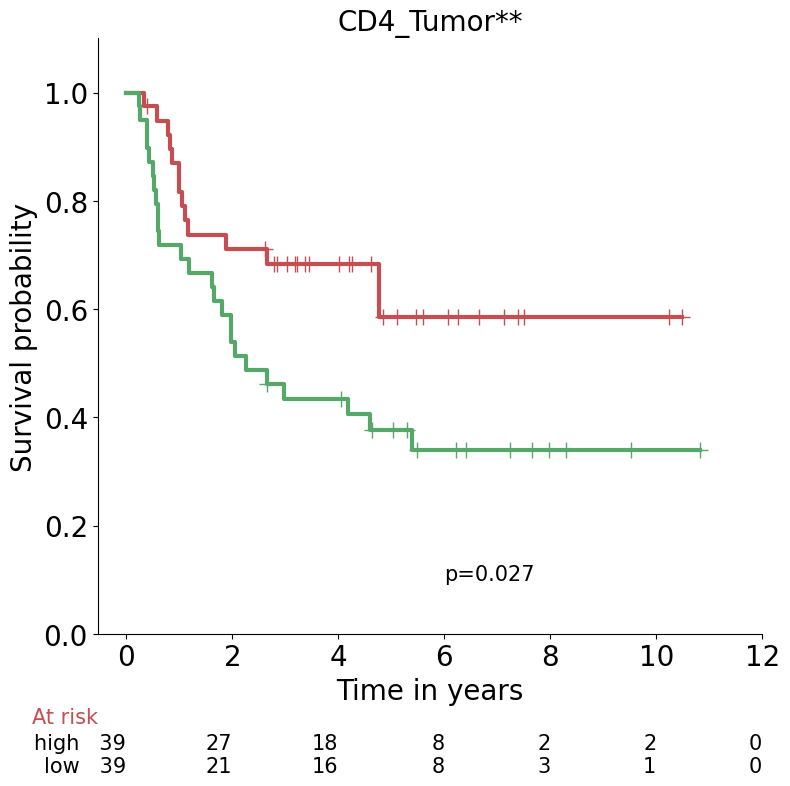

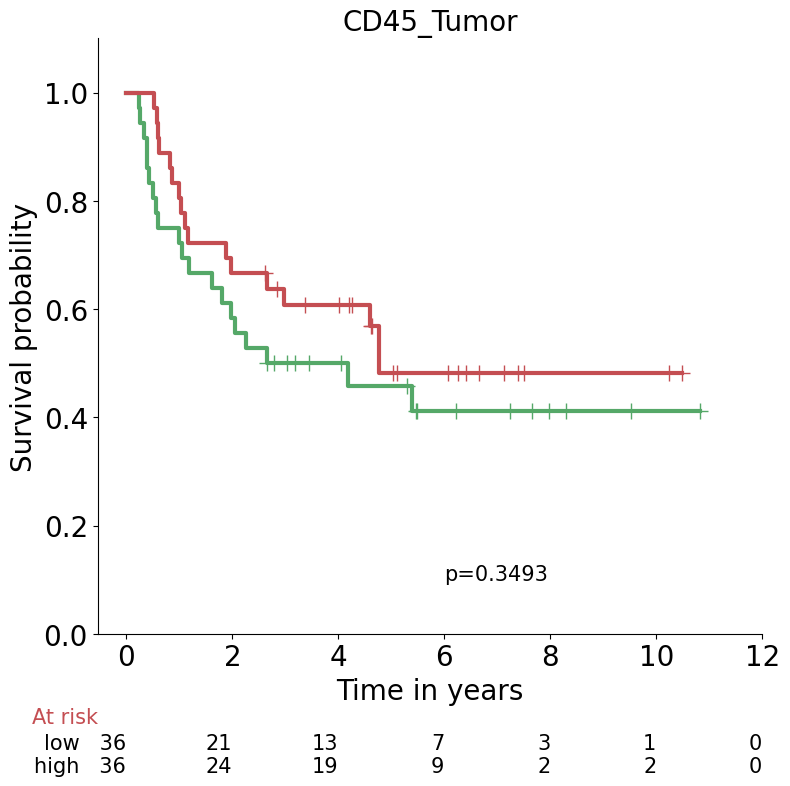

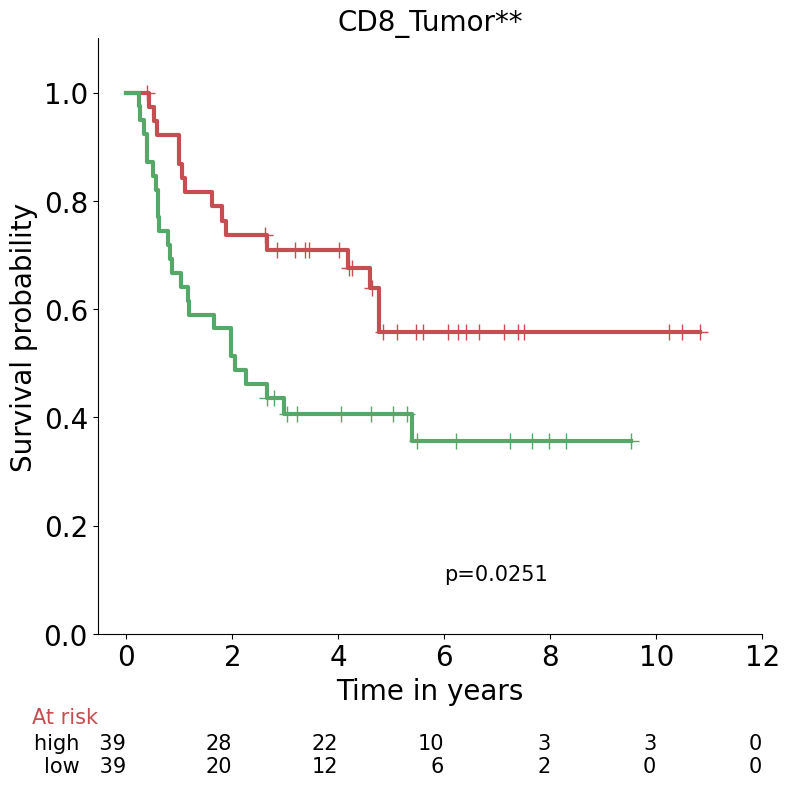

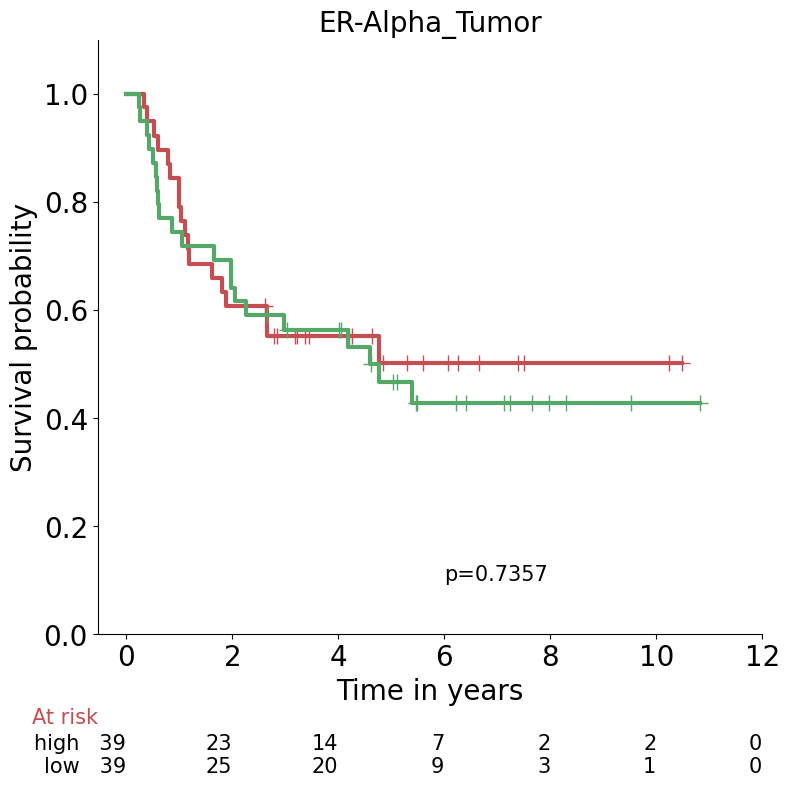

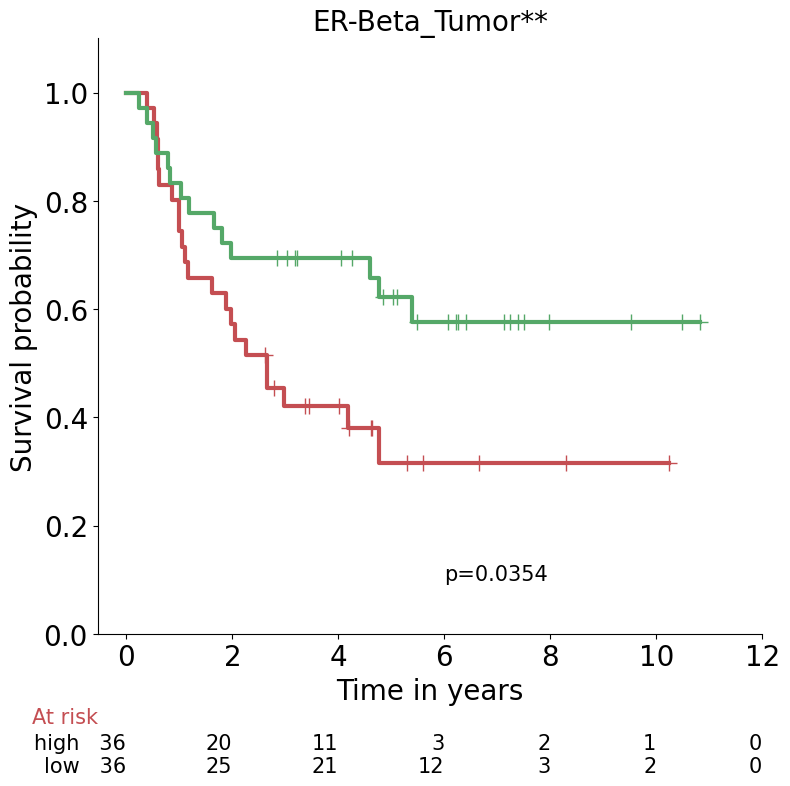

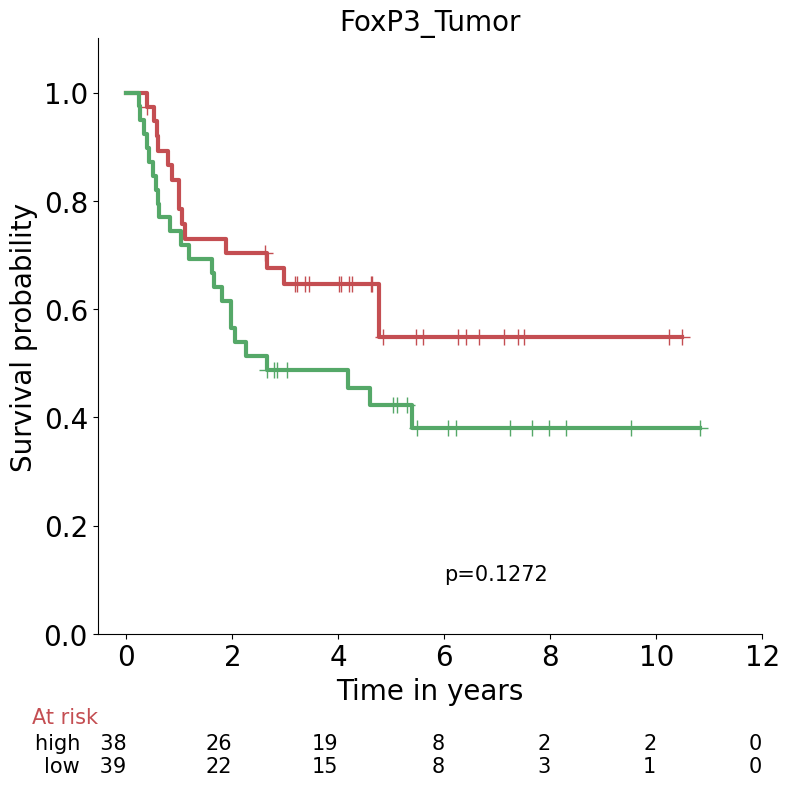

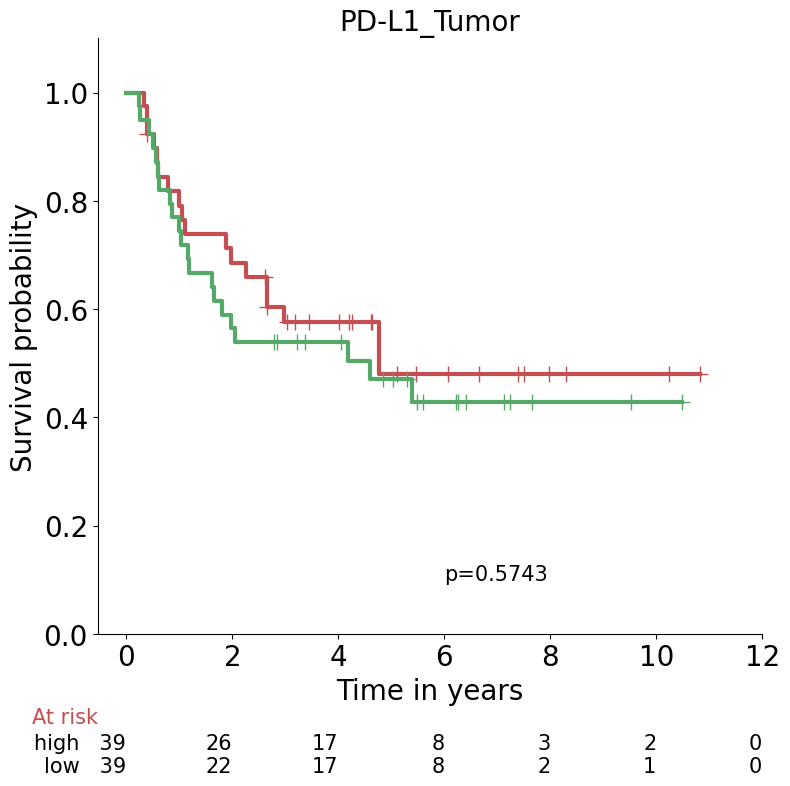

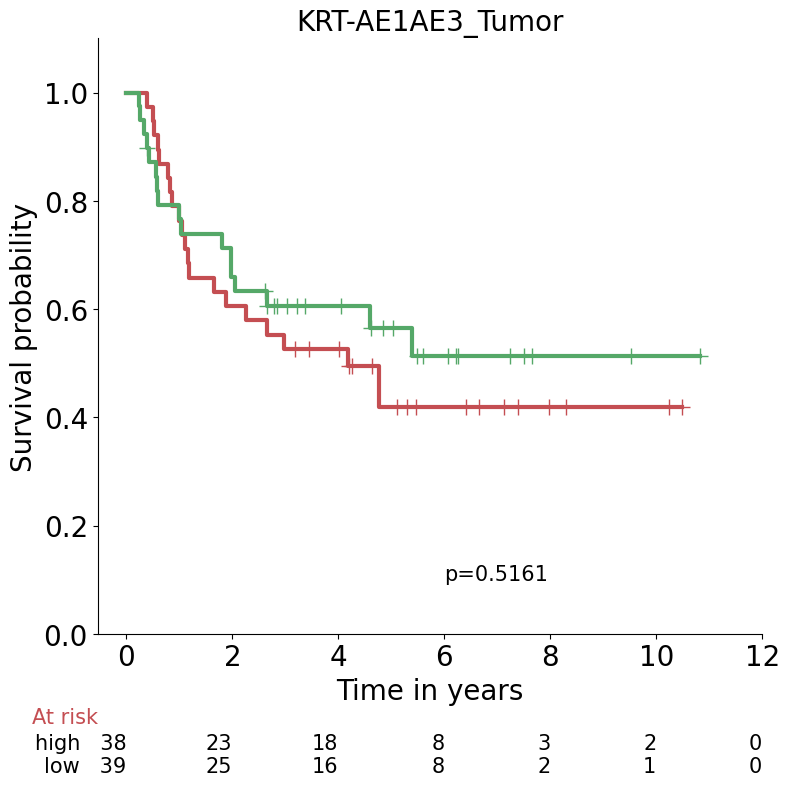

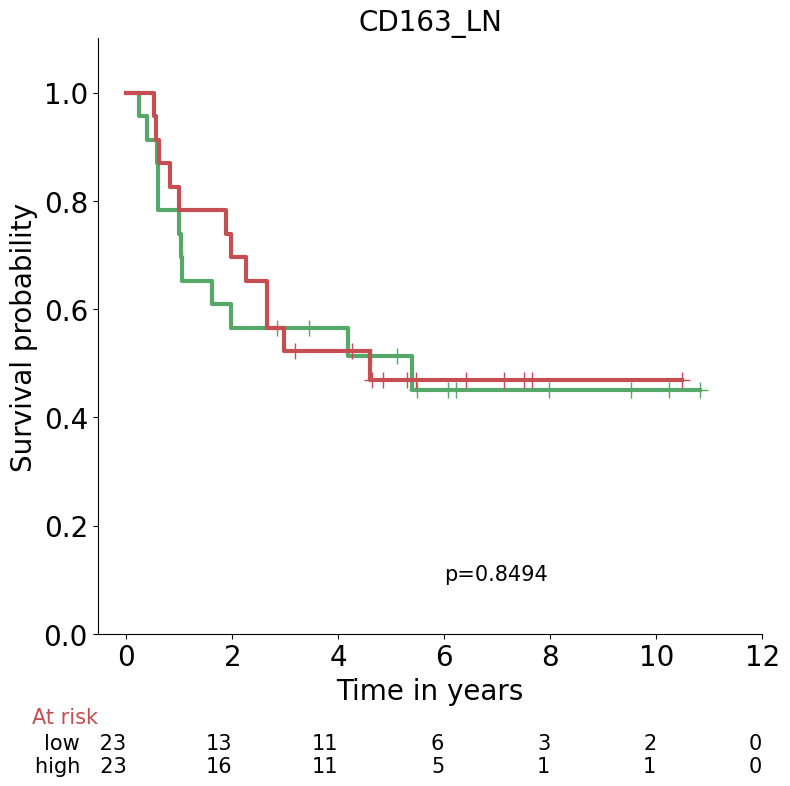

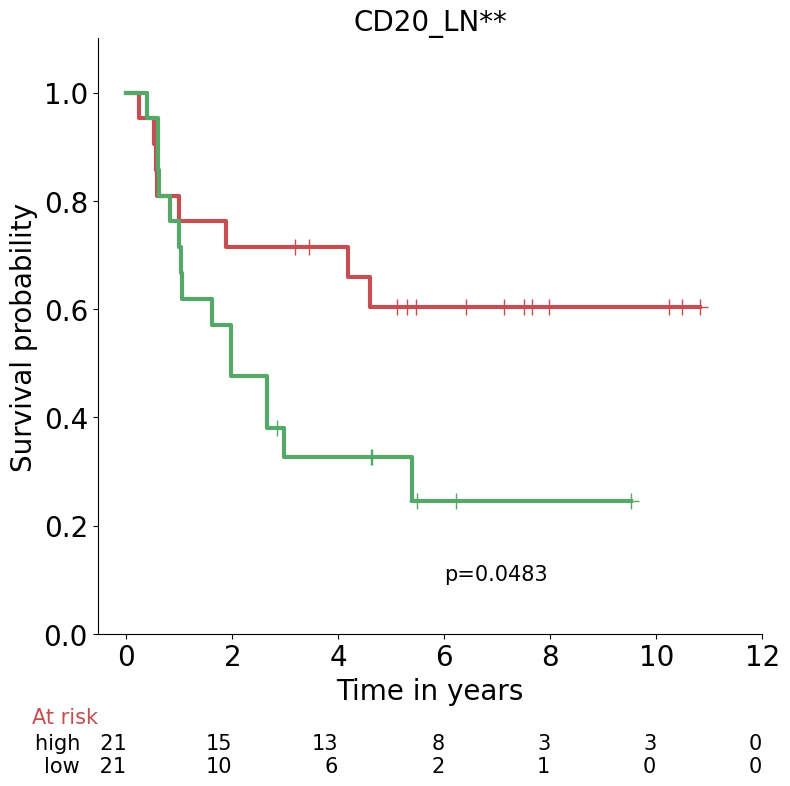

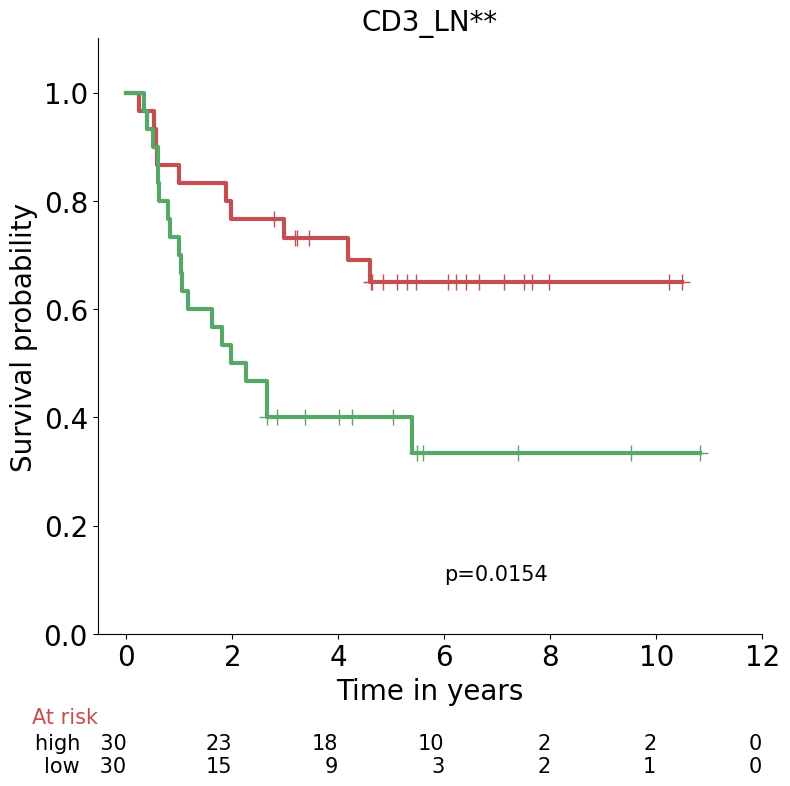

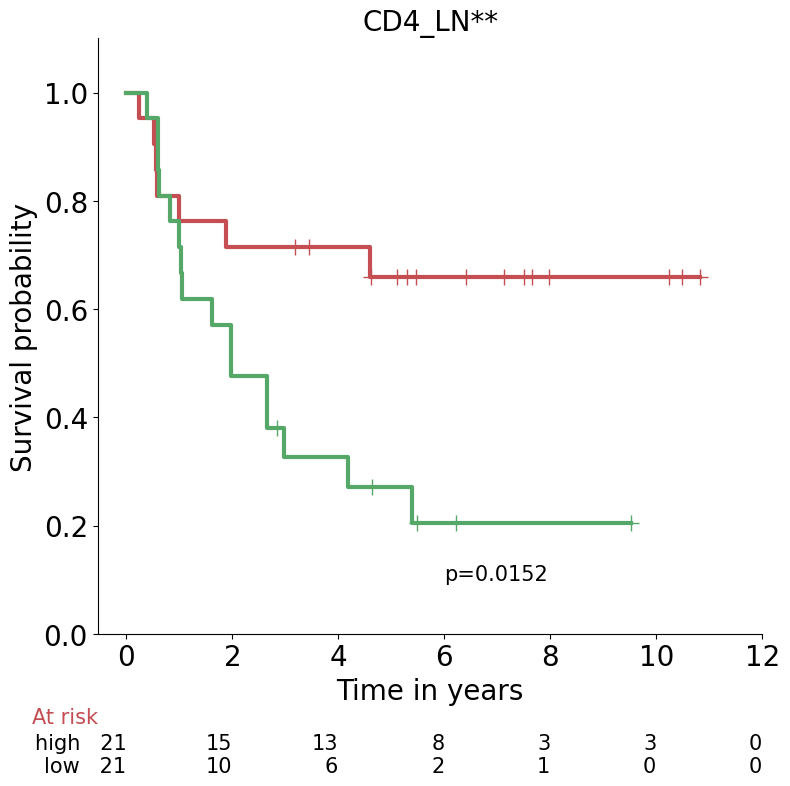

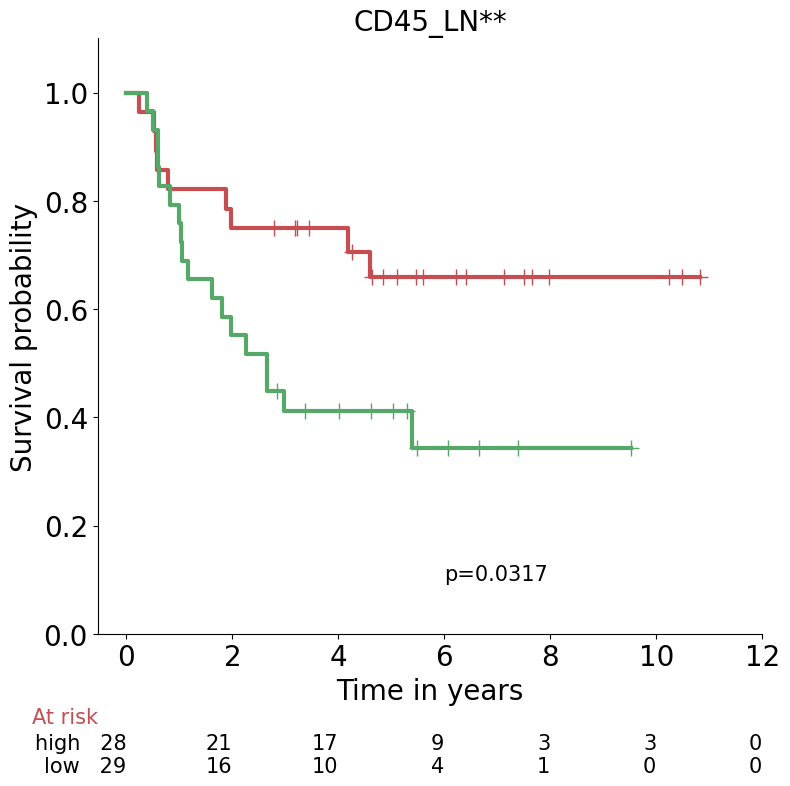

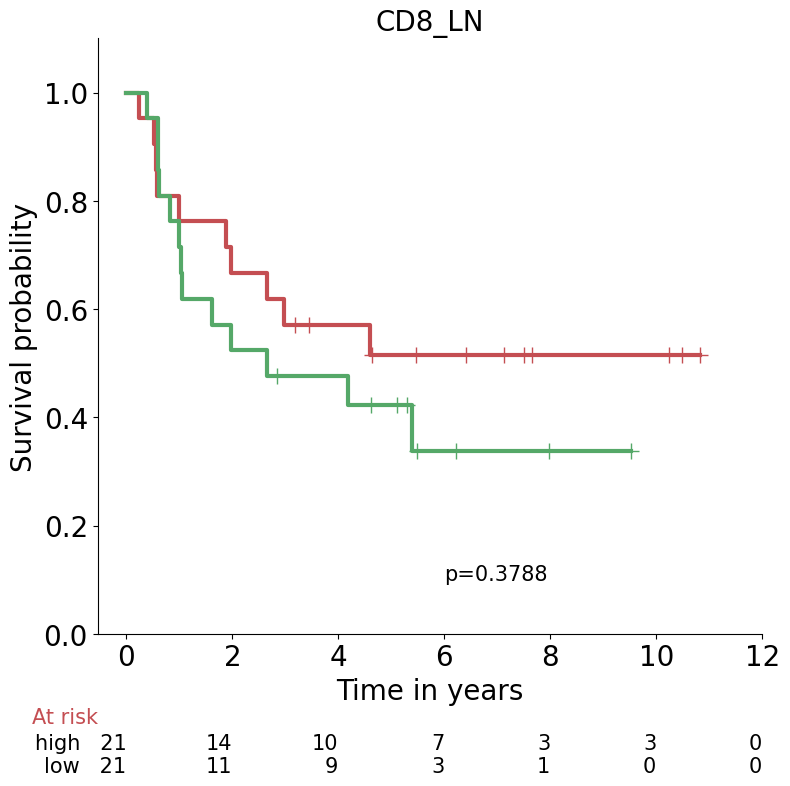

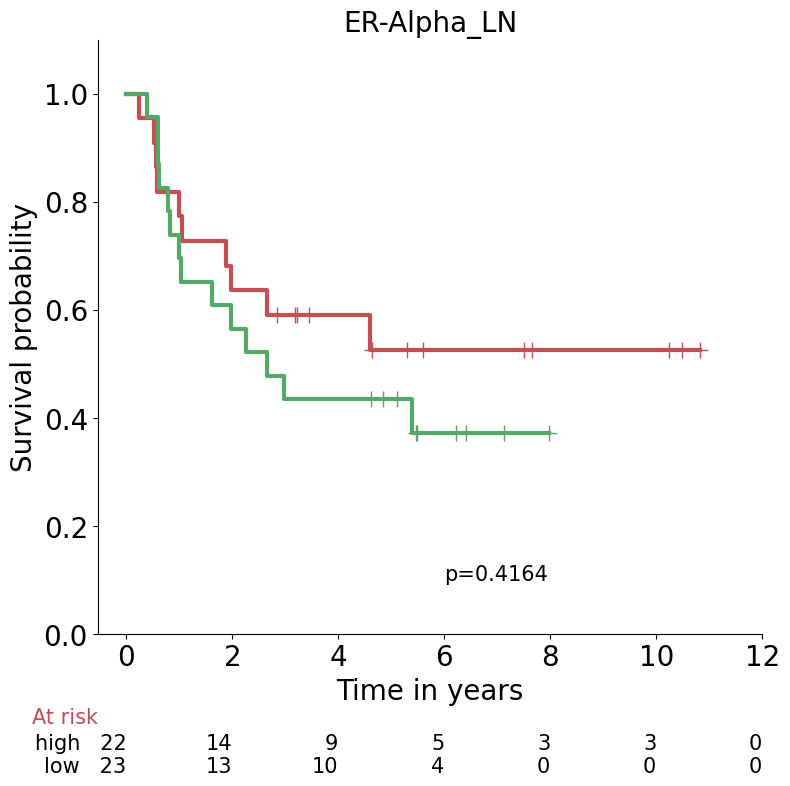

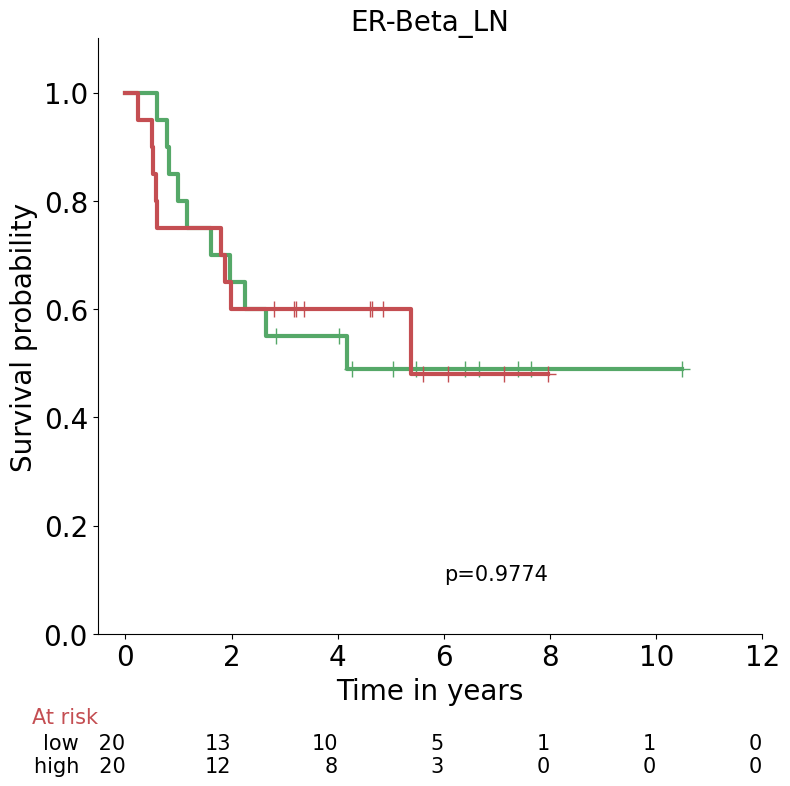

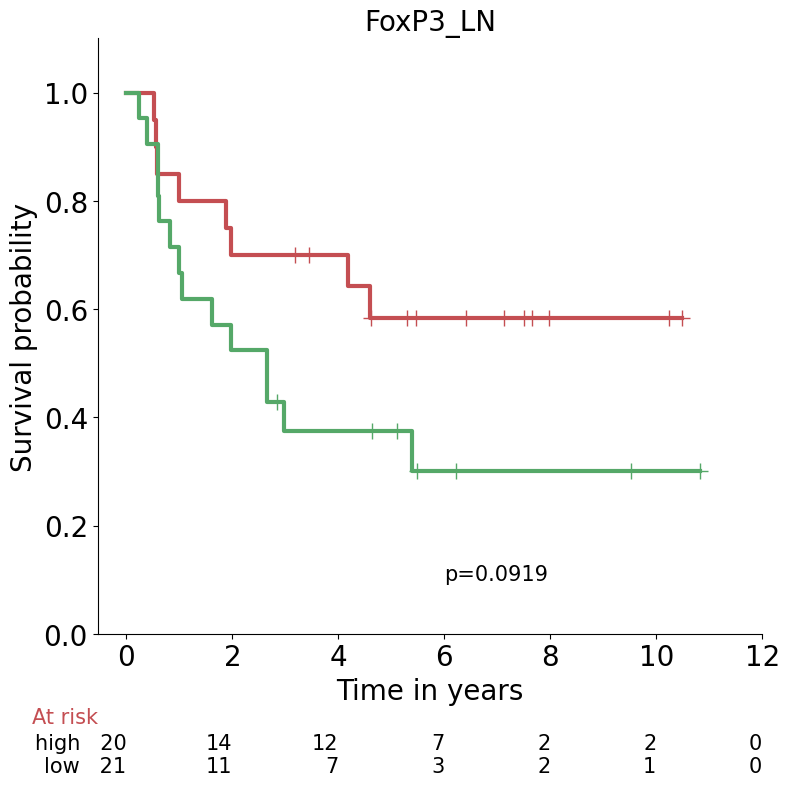

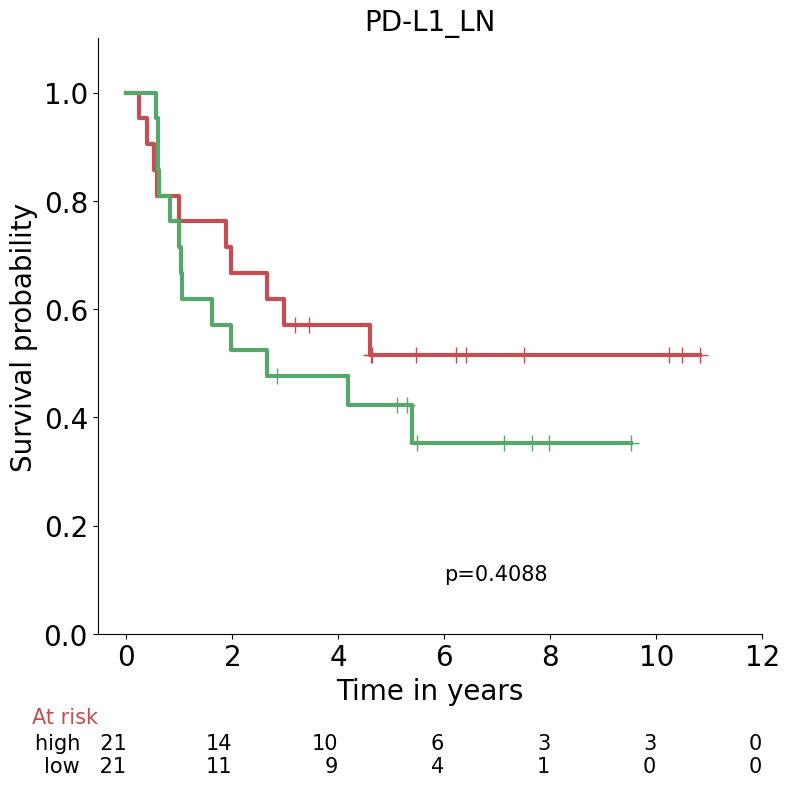

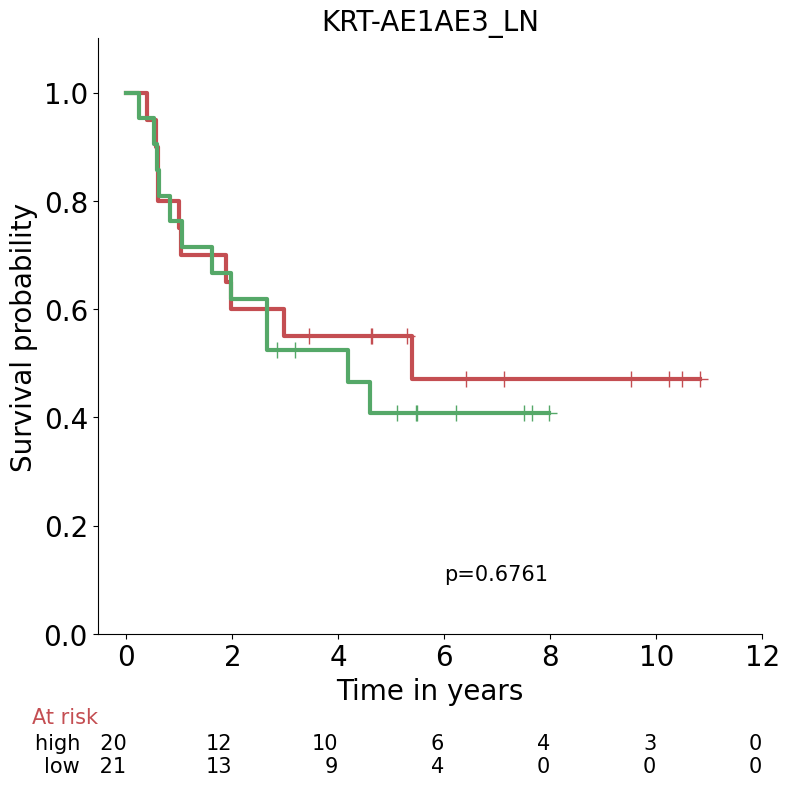

In [37]:


def plot_km_region_IHC_subtypes(region):
    '''region: options Tumor-for primary tumor, LN- for pN+ lymph node'''
    #marker list to read corresponding csvs
    marker_list=["CD163","CD20","CD3","CD4","CD45","CD8","ER-Alpha","ER-Beta","FoxP3","PD-L1","KRT-AE1AE3"]
    #median thresholding column in csv to quantify protein expression
    mode="median"
    for  i in marker_list:
        df=pd.read_csv(f"HE_IHC_comb_IN_{region}/" + i + "_quant_patient{}.csv".format(region))

        T=df['Years to Progression or Last Follow-up']
        C=df['Case'].astype(float)
        col=i+"_"+mode+"_"+"binary"
        colors={'high': 'r', 'low': 'g'}
        plt.figure(figsize=(8,8))
        fitters,labels,ax,d_list,e_list,G,colors=plot_km(col,df,T,C,colors) 

        df_rank = pd.DataFrame({
            'durations': d_list,
            'events': e_list,
            'groups': G
        })
        result = multivariate_logrank_test(df_rank['durations'], df_rank['groups'], df_rank['events'])
        result.test_statistic



        sns.despine()
        newxticks = []
        for x in ax.get_xticks():
            if x >= 0:
                newxticks += [x]

        ax.set_xticks(newxticks)
        if result.p_value< 0.05:
            plt.title('{}_{}**'.format(i,region), fontsize=20)
        else:
            plt.title('{}_{}'.format(i,region),fontsize=20)
        plt.text(6,.1,'p={}'.format(round(result.p_value,4)),fontsize=15)
        for line in plt.gca().lines:
            line.set_linewidth(3.)
        ax.legend().set_visible(False) 
        handles, labels = ax.get_legend_handles_labels()
        #ax.legend().set_visible(False)
        ax2=add_at_risk_counts_CUSTOM(fitters,ax=ax,fontsize=15,labels=labels,colors=colors) 
        plt.show()
        #plt.savefig('IHC_KM_{}/KM_{}_{}_IN_sub.png'.format(region,mode,i),dpi=500)
regions=["Tumor","LN"]
for region in regions:
    plot_km_region_IHC_subtypes(region)
